## 제주도 사용금액  데이터를 통한 소비행태 및 재난지원금 효과 분석

### 개요 

#### 1.1  프로젝트 주제
 * “공간정보를 활용한 탐색적 데이터 분석”이라는 주제로 2020년 5월~8월 제주지역 시간별, 업종별, 지역별 소비금액 및 재난지원금의 소비형태를 다양한 시각으로 분석하고 시각화하고자 합니다.

#### 1.2 프로젝트 목적

1) 제주도의 전반적인 소비행태 확인
 * 제주도는 관광산업이 매우 발달한 지역입니다. 또한 특정 지역을 제외하면 관광지와 주거지에 구분이 비교적 명확한 편입니다. 이에 지역별/ 업종별 소비 행태를 파악하고 이를 통해 지역적 특성을 파악하고자 합니다.

2) 재난지원금이 소비자와 소상공인, 자영업자 등 “서민" 경제에 도움을 주었는지 확인
 * 재난지원금은 소상공인ㆍ자영업자 등을 지원하고, 사회취약계층에 대한 사각지대를 살피는 등 코로나19의 위기로부터 국민 생활의 안정과 위축된 경제 회복을 위함에 목적이 있습니다.(행정안전부 발췌)
 * 이에 제주지역의 재난지원금 사용 행태를 기간(월/시간)별, 지역별, 업종별, 업종 규모별로 확인하고 실제 재난지원금이 소상공인과 자영업자, 서민들의 가계 경제에 도움이 되었는지를 확인해보고자 합니다.
 * 분석을 통해  재난지원금의 정책은 의도대로 진행되었는지, 의도와는 다른 양상의 소비행태를 보였는지 알아보고자 합니다.

#### 1.3 프로젝트 진행순서
 * 전반적인 data skimming을 시작으로 기간별(월/시간), 업종별, 업종규모별, 지역별 등으로 세분화하여 데이터 시각화를 진행하였습니다.
업종의 종류가 다양하여 각 기준별 상위 10개 업종 또는 자체적으로 구분한 카테고리별 분포를 집중적으로 확인하였습니다. 


# 데이터 주소 가져오기 
- 데이터 위도 경도를 wgs84 좌표로 변환
- 변환된 좌표값을 통해 카카오API 주소 변환을 이용하여 읍면동 주소 데이터를 가져옴 

In [ ]:
# sample 6월 

# 데이터 가져오기

raw_data_6 = pd.read_csv('../../1. raw_data/KRI-DAC_Jeju_data6.txt', sep=',')
raw_data_6.tail()

# 1. 좌표 변환 하기 

df_6 = raw_data_6.copy()

from pyproj import Proj, transform
# ITRF좌표계
proj_ITRF = Proj(init='epsg:5179')
# WGS 좌표계 
proj_WGS84 = Proj(init='epsg:4326')


df_6['lon'], df_6['lat'] = transform(proj_ITRF, proj_WGS84, df_6['POINT_X'], df_6['POINT_Y'])

# 2. 좌표 구분 컬럼 생성 

df_6['lon'] = df_6['lon'].astype(str)
df_6['lat'] = df_6['lat'].astype(str)
df_6['lon_lat'] = df_6['lon']+'_'+df_6['lat']
df_6['lon_lat'].value_counts()

# 3. 중복 좌표 삭제 > url 생성 

df_uniq = df_6.drop_duplicates('lon_lat')
df_uniq.value_counts('lon_lat')

# url 생성

df_uniq['url1'] = 'https://dapi.kakao.com/v2/local/geo/coord2regioncode.json?x=' + df_uniq['lon']
df_uniq['url2'] = '&y=' + df_uniq['lat']
df_uniq['url'] = df_uniq['url1'] + df_uniq['url2']


df_uniq.drop(columns=['url1','url2'],axis=1,inplace=True)
df_uniq = df_uniq.reset_index()
df_uniq.head(5)

# 4. API를 통해 주소 가져오기 

import requests
import json

dong_ls = []

for i in range(len(df_uniq.index)):
    url = df_uniq['url'][i]
    headers = {"Authorization": "<REST API KEY>"}
    api_test = requests.get(url, headers=headers)
    url_text = json.loads(api_test.text)
    dong = url_text['documents'][0]['region_3depth_name']
    dong_ls.append(dong)
print('converted point to addr')

# 가져온 주소값 df 변환 
dic = {'dong':dong_ls}
df_dong = pd.DataFrame(dic)
df_dong.tail(3)

# 5. df 와 merge 
df_join = df_uniq.join(df_dong)
df_join

# 변환된 주소값을 원본 데이터와 합치기 

df_addr = df_join[['lon_lat','dong']]
df_addr.tail(3)

# # 피클로 저장하기 

# import pickle
# with open('jeju_uniq_data6.pickle', 'wb') as fw:
#     pickle.dump(df_final, fw)

########## 전체 월에 대해 반복 작업 ############


# 데이터 업종 Type 분류 작업 
- 업종 Type 의 경우 200여개로 분류 작업을 진행하였습니다.


In [ ]:
# 2. 카테고리 추가하기 

jeju_cat.replace(dict.fromkeys(['택시', '기타교통수단', '통신기기'], '교통/통신'), inplace=True)
jeju_cat.replace(dict.fromkeys(['대형할인점', '농축협직영매장', '농협하나로클럽', '편의점', '슈퍼마켓', '정육점', '기타유통업', '연쇄점', '상품권', '인삼제품', '홍삼제품', '농축수산품', '주류판매점', '기타건강식', '건강식품(회원제형태)'], '마트/편의점(유통)'), inplace=True)
jeju_cat.replace(dict.fromkeys(['악기점', 'DVD음반테이프판매', '문화취미기타', '영화관', '티켓', '수족관', '화랑'], '영화/문화'), inplace=True)
jeju_cat.replace(dict.fromkeys(['내의판매점', '양품점', '옷감직물', '귀금속', '기타직물', '스포츠의류', '가방', '정장', '악세사리', '기타잡화', '신발', '기타의류', '단체복', '아동의류', '캐쥬얼의류', '맞춤복점', '제화점', '인터넷Mall', '인터넷종합Mall'], '쇼핑/패션'), inplace=True)
jeju_cat.replace(dict.fromkeys(['제과점', '스넥', '기타음료식품'], '카페/베이커리'), inplace=True)
jeju_cat.replace(dict.fromkeys(['미용재료', '화장품', '피부미용실', '미용원', '이용원'], '뷰티'), inplace=True)
jeju_cat.replace(dict.fromkeys(['구내매점', '단란주점', '주점', '서양음식', '일반한식', '일식회집', '중국음식',  '유흥주점', '칵테일바'], '외식/주점'), inplace=True)
jeju_cat.replace(dict.fromkeys(['세탁소', '애완동물', '화원', '침구수예점', '성인용품점', '가전제품', '기타가구', '조명기구', '민예공예품', '주방용식기', '기타전기제품', '소프트웨어', '주방용구', '카페트커텐천막', '컴퓨터', '카메라', '일반가구', '정수기', '철제가구', '시계', '안경', '사우나', '안마스포츠마사지', '사진관', '인테리어', 'CATV'], '생활/기타'), inplace=True)
jeju_cat.replace(dict.fromkeys(['완구점', '화방표구점', '문구용품', '일반서적', '출판인쇄물', '기타사무용', '사무기기', '전문서적', '정기간행물', '기타서적문구', '서적출판(회원제형태)'], '서점/문구'), inplace=True)
jeju_cat.replace(dict.fromkeys(['기타보험', '손해보험'], '금융'), inplace=True)
jeju_cat.replace(dict.fromkeys(['기념품점', '기타숙박업', '특급호텔', '2급호텔', '1급호텔', '콘도', '렌트카', '관광여행', '항공사', '여객선', '면세점'], '여행/숙박'), inplace=True)
jeju_cat.replace(dict.fromkeys(['레져용품수리', '스포츠레져용품', '골프용품', '노래방', '당구장', '골프경기장', '볼링장', '골프연습장', '헬스크럽', '레져업소(회원제형태)', '기타레져업', '종합레져타운', '수영장', '테니스장', '기타회원제형태업소', ], '레저/스포츠'), inplace=True)
jeju_cat.replace(dict.fromkeys(['유아원', '독서실', '보습학원', '기능학원', '기타교육', '외국어학원', '학원(회원제형태)', '예체능학원', '컴퓨터학원', '대학등록금', '학습지교육', '초중고교육기관'], '교육/육아'), inplace=True)
jeju_cat.replace(dict.fromkeys(['주유소', '자동차정비', 'LPG', '세차장', '유류판매', '이륜차판매', '윤활유전문판매', '자동차시트타이어', '중고자동차', '수입자동차', '자동차부품', '주차장', '기타자동차서비스', '카인테리어', ], '주유/자동차'), inplace=True)
jeju_cat.replace(dict.fromkeys(['약국', '종합병원', '기타의료기관및기기', '한약방', '제약회사', '의료용품', '건강진단', '한의원', '동물병원', '의원', '치과의원', '병원', '산후조리원', '치과병원'], '의료'), inplace=True)
jeju_cat.replace(dict.fromkeys(['목재석재철물', '건축요업품', '골동품점', '기계공구', '기타건축자재', '보일러펌프', '페인트', '냉열기기', '유리', '과학기자재', '기타광학품', '기타연료', '중장비수리', ], '건설/제조'), inplace=True)
jeju_cat.replace(dict.fromkeys(['기타농업관련', '비료농약사료종자', '농기계', '미곡상'], '농업'), inplace=True)
jeju_cat.replace(dict.fromkeys(['사무서비스', '기타대인서비스', '화물운송', '보관창고업', '종합용역', '조세서비스', '가례서비스', '공공요금', '위탁급식업', '기타용역서비스', '기타수리서비스', '기타운송', '가정용품수리', '견인서비스', '부동산중개임대', '부동산분양', '신변잡화수리', '사무통신기기수리', '법률회계서비스', '사무서비스(회원제형태)', '정보서비스', '기타업종', '기타비영리유통'], '서비스/기타'), inplace=True)

In [ ]:
# 카테고리 추가하기 
jeju_all['Category'] = jeju_cat['Type']
jeju_all.head()

# 환경설정. 

In [7]:
# import 해주기
from glob import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import pickle
import warnings
warnings.filterwarnings(action='ignore')
import gzip

from matplotlib import font_manager
# 한글설정(MAC)
f_path = '/Library/Fonts/NanumGothic.ttf'
font_manager.FontProperties(fname=f_path).get_name()
from matplotlib import rc
rc('font', family = 'NanumGothic')

# # #(한글 설정 WIN)
# from matplotlib import rc
# plt.rcParams['axes.unicode_minus'] = False
# f_path= "C:/Windows/Fonts/malgun.ttf"
# font_name= font_manager.FontProperties(fname=f_path).get_name()
# rc('font', family =font_name)
# plt.rc('font', family='Malgun Gothic')

import folium
from folium.plugins import MarkerCluster, MiniMap

pd.options.display.float_format = '{:.5f}'.format

In [8]:
# # 피클 저장하기 

# with open('jeju_all.pickle','wb') as fw:
#     pickle.dump(jeju_all, fw)

In [9]:
# 피클 불러오기 

with open('jeju_all.pickle','rb') as fr:
    jeju_all = pickle.load(fr)

jeju_all.tail(3)

OBJECTID  Field1      YM     SIDO SIGUNGU FranClass   Type Time  \
280082    278935  278935  202008  제주특별자치도    서귀포시        영세  예체능학원   x시   
280083    279538  279538  202008  제주특별자치도    서귀포시        영세   기타가구   x시   
280084    279785  279785  202008  제주특별자치도     제주시        영세  기타숙박업   x시   

        TotalSpent  DisSpent  NumofSpent  NumofDisSpent      POINT_X  \
280082      110000         0           1              0 921003.98200   
280083       50000         0           1              0 937500.16740   
280084       17470         0           2              0 941114.05310   

             POINT_Y                 lon                lat  \
280082 1476177.84050  126.65174159048293  33.27407883370635   
280083 1486052.75280  126.82818252032293  33.36422597166203   
280084 1503713.22230  126.86586853032782  33.52371304945294   

                                     lon_lat dong Category  
280082  126.65174159048293_33.27407883370635  남원읍    교육/육아  
280083  126.82818252032293_33.36422597166203  성산읍    생활/기타  
280084  126.86586853032782_33.52371304945294  구좌읍    여행/숙박

In [ ]:
##### 제주시 행정구역을 읍면동으로 구분하되 제주시의 시내동은 제주시로 통일하였고, 
##### 서귀포시 행정구역을 읍면동으로 구분하되 서귀포시의 시내동은 서귀포시로 통일하였습니다. 

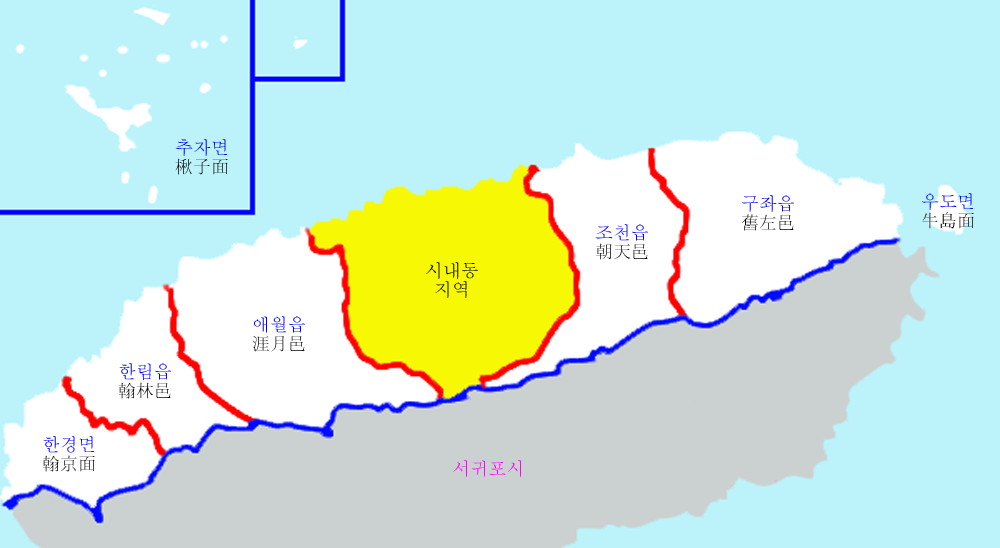

In [2]:
# 제주시 행정구역 이미지 (출처 : 위키백과)

from IPython.display import Image

Image('Jeju_city.png')

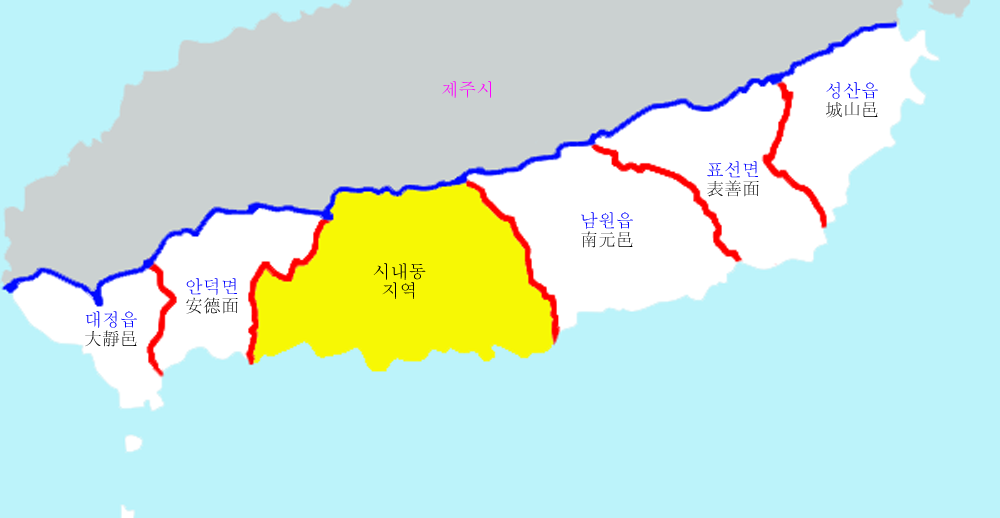

In [3]:
Image('Seogwipo_city.png')

In [42]:
# 제주시 --동 > 제주시로 통일
cond1 = jeju_all['SIGUNGU'] == '제주시'
cond2 = jeju_all['dong'].str.contains('동')
jeju_all['dong_cat'] = np.where(jeju_all['dong'].str.contains('동'),jeju_all['SIGUNGU'], jeju_all['dong'])

# 서귀포시 --동 > 서귀포시로 통일
cond1 = jeju_all['SIGUNGU'] == '서귀포시'
cond2 = jeju_all['dong'].str.contains('동')
jeju_all['dong_cat'] = np.where(jeju_all['dong'].str.contains('동'),jeju_all['SIGUNGU'], jeju_all['dong'])

jeju_all.tail(3)

OBJECTID  Field1      YM     SIDO SIGUNGU FranClass   Type Time  \
280082    278935  278935  202008  제주특별자치도    서귀포시        영세  예체능학원    x   
280083    279538  279538  202008  제주특별자치도    서귀포시        영세   기타가구    x   
280084    279785  279785  202008  제주특별자치도     제주시        영세  기타숙박업    x   

        TotalSpent  DisSpent  NumofSpent  NumofDisSpent      POINT_X  \
280082      110000         0           1              0 921003.98200   
280083       50000         0           1              0 937500.16740   
280084       17470         0           2              0 941114.05310   

             POINT_Y                 lon                lat  \
280082 1476177.84050  126.65174159048293  33.27407883370635   
280083 1486052.75280  126.82818252032293  33.36422597166203   
280084 1503713.22230  126.86586853032782  33.52371304945294   

                                     lon_lat dong Category Time_cut  dis/tot  \
280082  126.65174159048293_33.27407883370635  남원읍    교육/육아    무승인거래  0.00000   
280083  126.82818252032293_33.36422597166203  성산읍    생활/기타    무승인거래  0.00000   
280084  126.86586853032782_33.52371304945294  구좌읍    여행/숙박    무승인거래  0.00000   

        count dong_cat  
280082      1      남원읍  
280083      1      성산읍  
280084      1      구좌읍

In [10]:
# Time에 '시'를 제거해 줍니다.
jeju_all['Time']= jeju_aall['Time'].str.replace('시', '')

# 시간을 큰 범위로 변화해 줍니다.
def time_cut(x):
    if '06'> x >='02':
        return '새벽'
    elif '11'> x >= '06':
        return '오전'
    elif '15' > x >= '11':
        return '점심'
    elif '18' > x >= '15':
        return '오후'
    elif  '22'> x >= '18':
        return '저녁'
    else:
        return '심야'

In [11]:
# 함수 적용
jeju_all['Time_cut'] = jeju_all['Time'].apply(time_cut)

jeju_all.loc[jeju_all['Time']=='x', 'Time_cut'] ='무승인거래'

# 1. 제주도 소비 전반적 시각화(EDA) 

In [12]:
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import seaborn as sns 

## 1) 기간별/지역별/업종별 시각화

<AxesSubplot:xlabel='Category', ylabel='TotalSpent'>

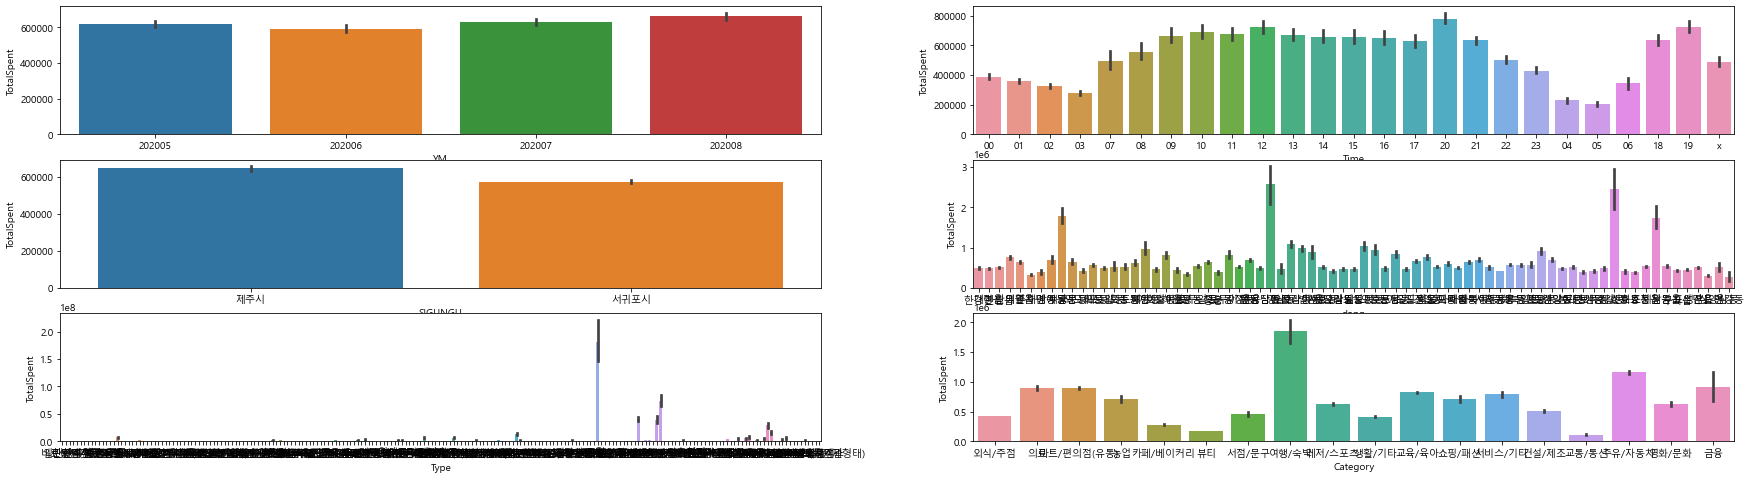

In [7]:
# 총사용금액으로 각 컬럼별 데이터 분석 

figure, ((ax1,ax2), (ax3,ax4),(ax5,ax6)) = plt.subplots(nrows=3, ncols=2)
figure.set_size_inches(30,8)

sns.barplot(data=jeju_all, x="YM", y="TotalSpent", ax=ax1)  #월별 총사용금액 
sns.barplot(data=jeju_all, x="Time", y="TotalSpent", ax=ax2)  #시간대별 총 사용금액 
sns.barplot(data=jeju_all, x="SIGUNGU", y="TotalSpent", ax=ax3) #제주/서귀포 총 사용금액
sns.barplot(data=jeju_all, x="dong", y="TotalSpent", ax=ax4) # 읍면동별 총 사용금액 
sns.barplot(data=jeju_all, x="Type", y="TotalSpent", ax=ax5) # 업종별 사용금액 
sns.barplot(data=jeju_all, x="Category", y="TotalSpent", ax=ax6) # 업종구분별 사용금액 

* 월별 : 제주도의 총사용금액은 8월>7월 > 5월 > 6월 순으로 컸지만, 많은 차이를 보이진 않았습니다.
* 시간별 : 총 사용금액을 시간별로 분석해보면 저녁 식사시간대가 가장 높았고 다음으로는 점심식사 시간대가 높았습니다.
* 지역별 : 제주시가 서귀포시보다 총 사용금액이 높았습니다.
* 업종별 : 여행/숙박(면세점 포함)에서 총 사용금액이 높았고 주유소/자동차, 마트/편의점 순으로 높았습니다. 

## 2) 월별 소비 상위 10개 업종 분석(이용건수 기준)

In [17]:
# 월별 업종별로 그룹핑하여 평균 구하기

jeju_type = jeju_all.groupby(['YM', 'Type'], as_index=False).mean()

업종별 총 이용건수의 편차가 심하여 편차를 줄이고 시각화 하고자 이용건수 컬럼의 정규화를 진행하였습니다.

In [18]:
# 총 이용건수와 총 재난지원금 이용건수 컬럼의 정규화 과정
## 월별로 각 컬럼의 최대값으로 나누어 줌

col = ['NumofSpent', 'NumofDisSpent']
num_jeju_type_5 = (jeju_type[jeju_type['YM'] == 202005][col]) / (jeju_type[jeju_type['YM'] == 202005][col].max())
num_jeju_type_6 = (jeju_type[jeju_type['YM'] == 202006][col]) / (jeju_type[jeju_type['YM'] == 202006][col].max())
num_jeju_type_7 = (jeju_type[jeju_type['YM'] == 202007][col]) / (jeju_type[jeju_type['YM'] == 202007][col].max())
num_jeju_type_8 = (jeju_type[jeju_type['YM'] == 202008][col]) / (jeju_type[jeju_type['YM'] == 202008][col].max())

norm_jeju_type_5 = jeju_type[jeju_type['YM'] == 202005].copy()
norm_jeju_type_6 = jeju_type[jeju_type['YM'] == 202006].copy()
norm_jeju_type_7 = jeju_type[jeju_type['YM'] == 202007].copy()
norm_jeju_type_8 = jeju_type[jeju_type['YM'] == 202008].copy()

norm_jeju_type_5[col] = num_jeju_type_5[col]
norm_jeju_type_6[col] = num_jeju_type_6[col]
norm_jeju_type_7[col] = num_jeju_type_7[col]
norm_jeju_type_8[col] = num_jeju_type_8[col]

### 2-1) 총 이용건수  상위 10개 업종

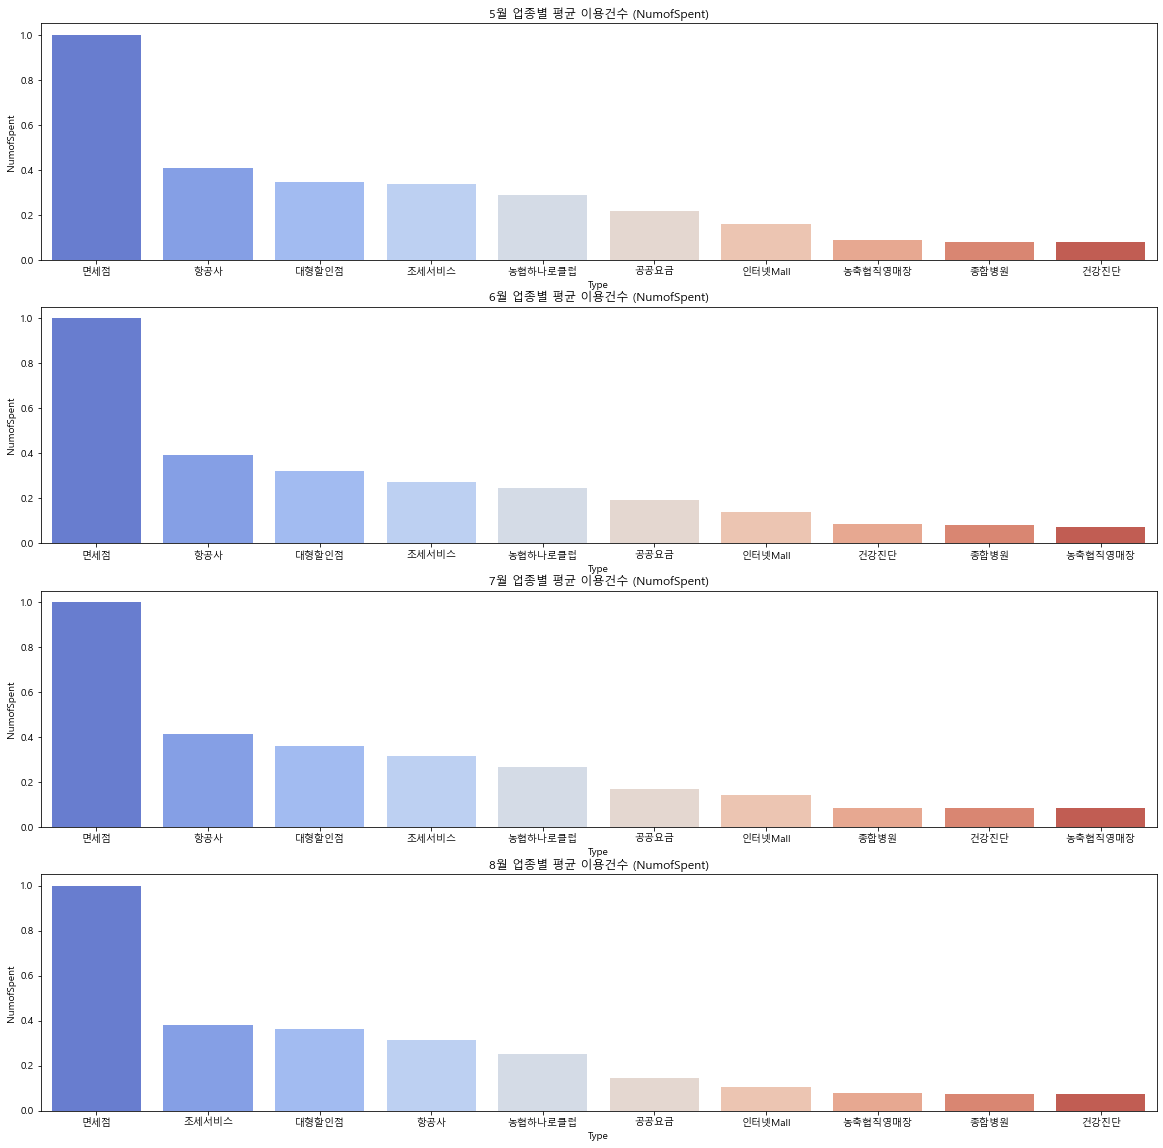

In [21]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(411)
ax1 = sns.barplot(x='Type', y='NumofSpent', data=norm_jeju_type_5.nlargest(10, 'NumofSpent'), palette='coolwarm')
ax1.set_title('5월 업종별 평균 이용건수 (NumofSpent)')

ax2 = fig.add_subplot(412)
ax2 = sns.barplot(x='Type', y='NumofSpent', data=norm_jeju_type_6.nlargest(10, 'NumofSpent'), palette='coolwarm')
ax2.set_title('6월 업종별 평균 이용건수 (NumofSpent)')

ax3 = fig.add_subplot(413)
ax3 = sns.barplot(x='Type', y='NumofSpent', data=norm_jeju_type_7.nlargest(10, 'NumofSpent'), palette='coolwarm')
ax3.set_title('7월 업종별 평균 이용건수 (NumofSpent)')

ax4 = fig.add_subplot(414)
ax4 = sns.barplot(x='Type', y='NumofSpent', data=norm_jeju_type_8.nlargest(10, 'NumofSpent'), palette='coolwarm')
ax4.set_title('8월 업종별 평균 이용건수 (NumofSpent)')
plt.show()

#### 월별 평균 이용건수 TOP10 업종
월별 평균 이용건수가 높은 상위 10개 업종들은 크게 달라지지 않았습니다.
- 면세점, 항공사와 같이 관광업종이 상위권을 차지하지만 휴가철이 끝나가는 8월에는 항공사의 순위가 떨어지는 것을 볼 수 있습니다.

### 2-2) 재난지원금 이용건수  상위 10개 업종

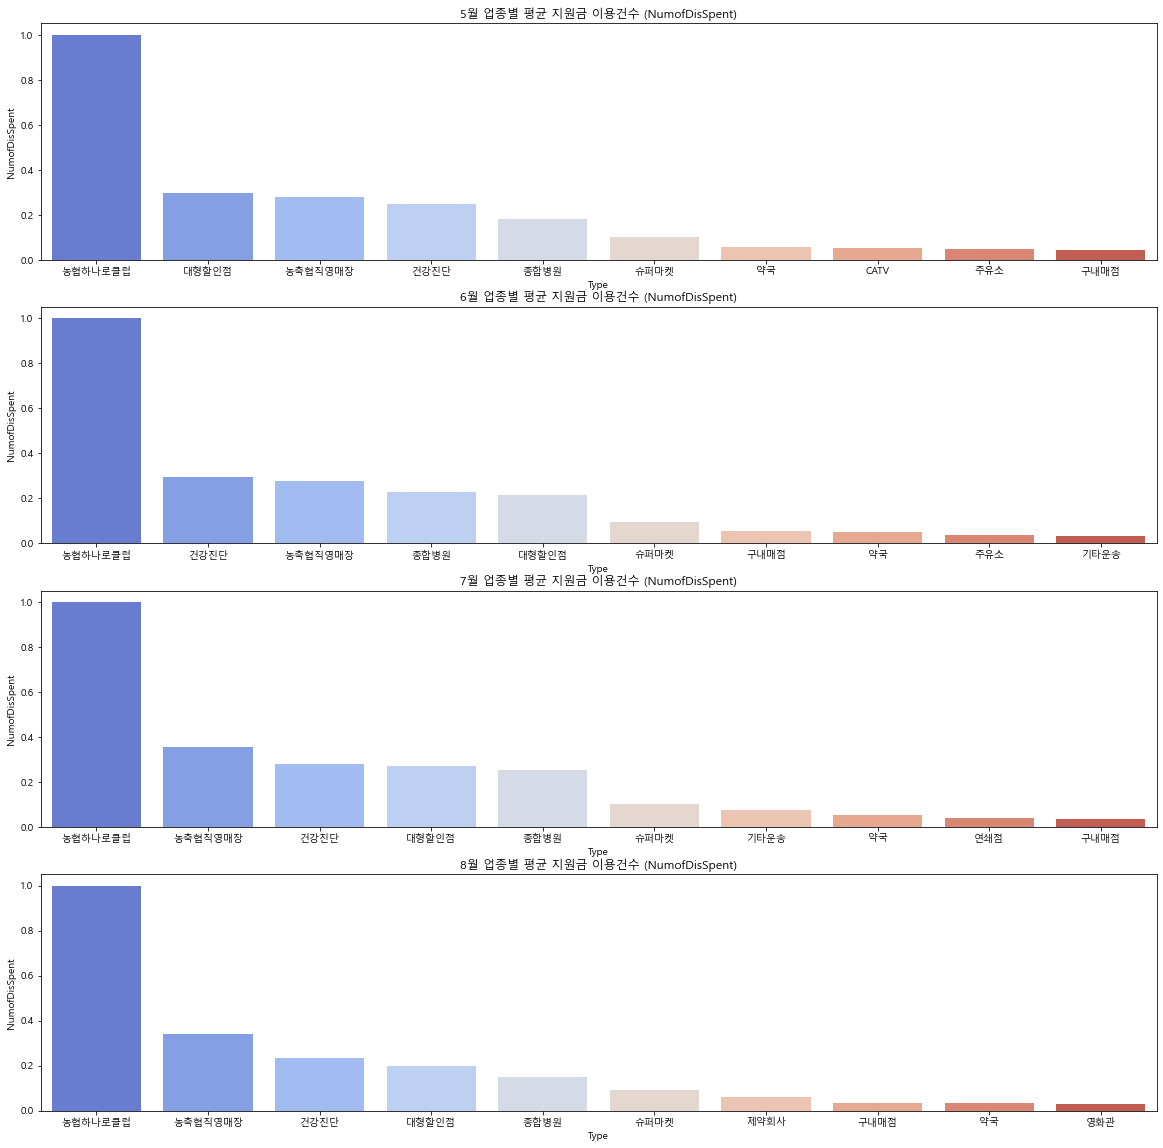

In [22]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(411)
ax1 = sns.barplot(x='Type', y='NumofDisSpent', data=norm_jeju_type_5.nlargest(10, 'NumofDisSpent'), palette='coolwarm')
ax1.set_title('5월 업종별 평균 지원금 이용건수 (NumofDisSpent)')

ax2 = fig.add_subplot(412)
ax2 = sns.barplot(x='Type', y='NumofDisSpent', data=norm_jeju_type_6.nlargest(10, 'NumofDisSpent'), palette='coolwarm')
ax2.set_title('6월 업종별 평균 지원금 이용건수 (NumofDisSpent)')

ax3 = fig.add_subplot(413)
ax3 = sns.barplot(x='Type', y='NumofDisSpent', data=norm_jeju_type_7.nlargest(10, 'NumofDisSpent'), palette='coolwarm')
ax3.set_title('7월 업종별 평균 지원금 이용건수 (NumofDisSpent)')

ax4 = fig.add_subplot(414)
ax4 = sns.barplot(x='Type', y='NumofDisSpent', data=norm_jeju_type_8.nlargest(10, 'NumofDisSpent'), palette='coolwarm')
ax4.set_title('8월 업종별 평균 지원금 이용건수 (NumofDisSpent)')
plt.show()

#### 월별 평균 재난지원금 이용건수 TOP10 업종

재난지원금은 주로 생활 밀착형 업종에서 많이 사용되는 것을 볼 수 있습니다.
- 마트, 의료 업종에서 평균 이용건수가 많습니다.

## 3) 시간별 소비 상위 10개 업종 분석.

In [13]:
def df_time(b,c):
    """
    b는 DisSpent or TotalSpent
    c는 시간을 문자열로
    """
    df_temp= jeju_all.groupby(['Time','Type'])[b].sum()
    df_temp=pd.DataFrame(df_temp).sort_values(b, ascending=False)
    df_temp.reset_index(inplace=True)
    return df_temp[df_temp['Time']==c].reset_index().head(10)

### 3-1) 제주도 전체

### 총사용금액

In [14]:
# 전체 시간별, 제주도 업종별 상위 10개 총사용금액을 나타냅니다.(총사용금액)

df_total=[]
for i in range(24):
    if i < 10:
        i= '0'+ str(i)
        df_temp = df_time('TotalSpent', i)
        df_total.append(df_temp)
    else:
        df_temp = df_time('TotalSpent', str(i))
        df_total.append(df_temp)

pd.options.display.max_columns = len(pd.concat(df_total, axis=1).drop(['index'], axis=1).columns)    
pd.concat(df_total, axis=1).drop(['index'], axis=1)

Time     Type  TotalSpent Time     Type  TotalSpent Time     Type  \
0   00     일반한식  1677964446   01     유흥주점  1249479291   02     유흥주점   
1   00     유흥주점  1377319834   01     일반한식  1067636731   02     일반한식   
2   00      편의점  1069768561   01     단란주점   749281631   02     단란주점   
3   00     단란주점   830214940   01      편의점   679859251   02      편의점   
4   00       주점   509761373   01       주점   341764534   02       주점   
5   00     서양음식   321363660   01     서양음식   198590170   02     서양음식   
6   00  인터넷Mall   240513708   01  인터넷Mall   134106140   02    기타숙박업   
7   00       스넥   209400622   01    기타숙박업   111966230   02     칵테일바   
8   00      항공사   207568300   01      항공사   101958200   02     슈퍼마켓   
9   00    기타숙박업   180355240   01     슈퍼마켓    92225069   02  인터넷Mall   

   TotalSpent Time   Type  TotalSpent Time   Type  TotalSpent Time     Type  \
0  1007309043   03   유흥주점   653158048   04   유흥주점   379003070   05      편의점   
1   678892520   03   일반한식   435681960   04    편의점   252701189   05     유흥주점   
2   514091710   03    편의점   317351210   04   일반한식   233843823   05     일반한식   
3   460379818   03   단란주점   221701567   04   단란주점    84479600   05      주유소   
4   202897286   03     주점    85962917   04    주유소    68082098   05     슈퍼마켓   
5   108812830   03  기타숙박업    61122316   04   슈퍼마켓    46345350   05       콘도   
6    87150953   03   서양음식    58335890   04  기타숙박업    43602805   05     단란주점   
7    69165300   03   슈퍼마켓    51316040   04     주점    43211750   05    기타숙박업   
8    66423000   03    주유소    37764931   04     콘도    40197111   05  인터넷Mall   
9    51352731   03   칵테일바    37084400   04   칵테일바    25252900   05      사우나   

   TotalSpent Time   Type  TotalSpent Time    Type  TotalSpent Time     Type  \
0   361632160   06    편의점   747650198   07     주유소  1433628112   08      주유소   
1   205036410   06    주유소   684430334   07     편의점  1183994930   08     슈퍼마켓   
2   170665661   06    면세점   374592550   07     면세점  1048981340   08      편의점   
3   148038414   06  골프경기장   328863860   07    슈퍼마켓   766076990   08      면세점   
4    82875930   06   일반한식   282537588   07    일반한식   515848481   08     일반한식   
5    51709954   06   슈퍼마켓   249946350   07   골프경기장   486726393   08      유아원   
6    42631100   06   화물운송   115414340   07     유아원   195756820   08  농축협직영매장   
7    35700945   06   유흥주점   106507550   07  기타건축자재   190737881   08     종합병원   
8    24885807   06     콘도    94380349   07      콘도   177745920   08      렌트카   
9    24486100   06   특급호텔    62076494   07    서양음식   151102503   08       콘도   

   TotalSpent Time     Type  TotalSpent Time     Type  TotalSpent Time  Type  \
0  1967525272   09      유아원  2480693770   10     슈퍼마켓  2724037069   11  일반한식   
1  1388544035   09      주유소  2286527782   10      유아원  2685803080   11  슈퍼마켓   
2  1360138660   09     슈퍼마켓  2265661918   10     일반한식  2559795563   11   주유소   
3  1357449480   09      면세점  1689285439   10      주유소  2433437286   11   면세점   
4   850813399   09     일반한식  1550875385   10      면세점  2042548965   11   유아원   
5   798452610   09       약국  1345630484   10     종합병원  1734857960   11    약국   
6   535898508   09      편의점  1284002320   10       약국  1649190081   11  서양음식   
7   436501790   09       의원  1157720900   10       의원  1615744544   11    의원   
8   424367835   09     종합병원  1123267880   10      편의점  1322551390   11  종합병원   
9   395657005   09  농축협직영매장   969396584   10  농축협직영매장  1289913129   11   편의점   

   TotalSpent Time   Type   TotalSpent Time     Type   TotalSpent Time  \
0  5573935461   12   일반한식  12985457998   13     일반한식  10097859576   14   
1  2760287062   12   서양음식   2866544773   13     슈퍼마켓   3040643477   14   
2  2473699690   12   슈퍼마켓   2838139019   13     서양음식   2923637873   14   
3  2323183870   12    면세점   2819389960   13      면세점   2710893593   14   
4  2080548570   12    주유소   2356295666   13      주유소   2507035494   14   
5  1642855336   12  골프경기장   2291905588   13    골프경기장   1982682489   14   
6  1627999470   12    편의점   1864684715   13      유아원   1819731050   14

Text(0.5, 0.98, '제주도 시간별 소비현황')

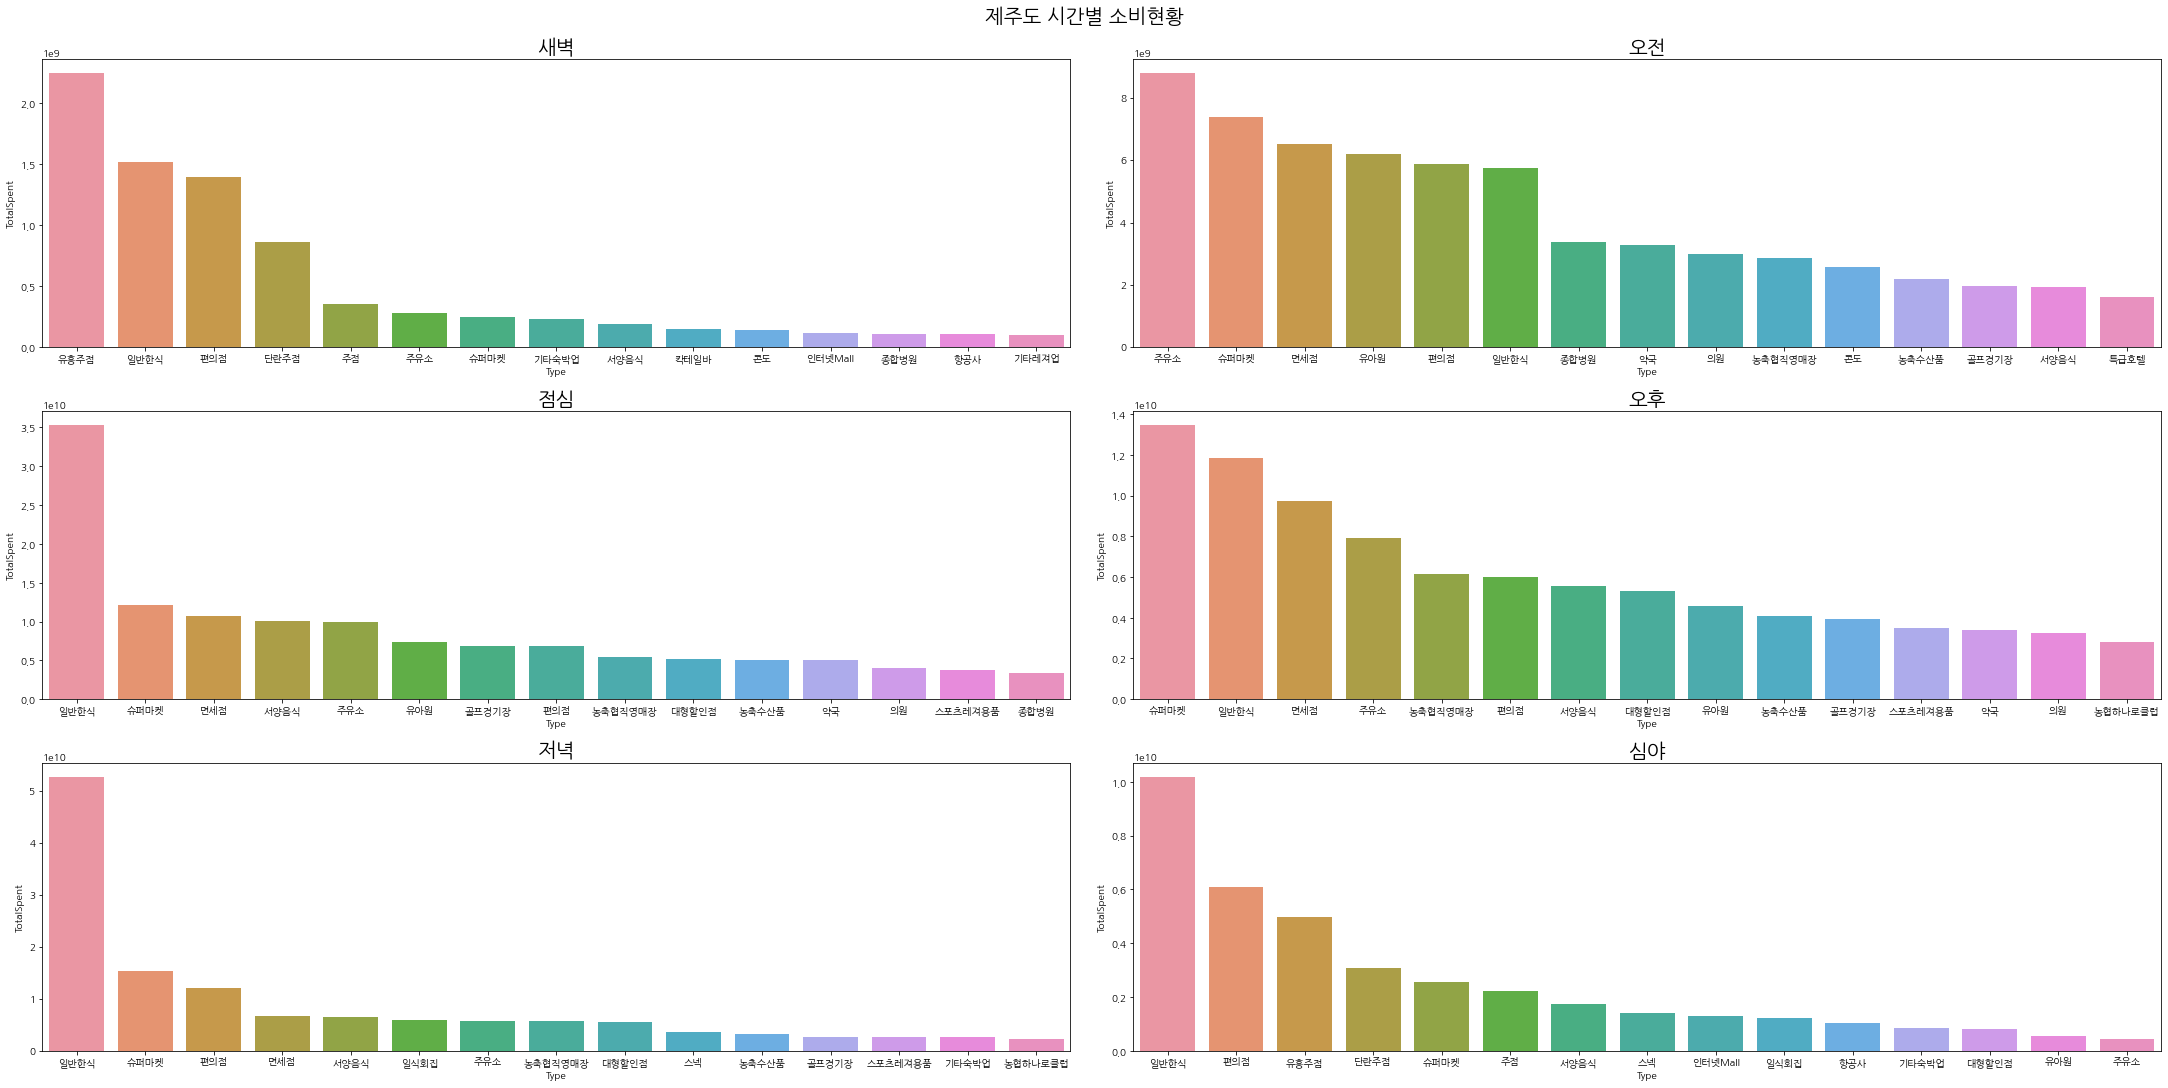

In [15]:
df_total_graph=[]
for i in list(('새벽', '오전', '점심', '오후', '저녁', '심야')):
           
    df_temp= jeju_all.groupby(['Time_cut','Type'])['TotalSpent'].sum()
    df_temp=pd.DataFrame(df_temp).sort_values('TotalSpent', ascending=False)
    df_temp.reset_index(inplace=True)
    df_total_graph.append(df_temp[df_temp['Time_cut']==i].reset_index(drop=True).head(15))

    
df_graph = pd.concat(df_total_graph, axis=0)
figure, ((ax1,ax2), (ax3,ax4),(ax5,ax6)) = plt.subplots(nrows=3, ncols=2, constrained_layout=True)
figure.set_size_inches(30,15)

sns.barplot(data=df_graph[df_graph['Time_cut']=='새벽'], x="Type", y="TotalSpent", ax=ax1)  
sns.barplot(data=df_graph[df_graph['Time_cut']=='오전'],  x="Type", y="TotalSpent", ax=ax2)  
sns.barplot(data=df_graph[df_graph['Time_cut']=='점심'],  x="Type", y="TotalSpent", ax=ax3) 
sns.barplot(data=df_graph[df_graph['Time_cut']=='오후'],  x="Type",y="TotalSpent", ax=ax4)  
sns.barplot(data=df_graph[df_graph['Time_cut']=='저녁'],  x="Type", y="TotalSpent", ax=ax5)  
sns.barplot(data=df_graph[df_graph['Time_cut']=='심야'],  x="Type", y="TotalSpent", ax=ax6)

ax1.set_title("새벽", fontsize=20)
ax2.set_title("오전", fontsize=20)
ax3.set_title("점심", fontsize=20)
ax4.set_title("오후", fontsize=20)
ax5.set_title("저녁", fontsize=20)
ax6.set_title("심야", fontsize=20)
plt.suptitle('제주도 시간별 소비현황' ,fontsize=20)

#### 제주도에서 시간별로 많이 소비되는 업종을 살펴보면
* 새벽 : 주점과 편의점에서 많이 소비합니다.
* 오전 : 주유소의 소비가 높습니다.(출근시간의 영향으로 판단됩니다.)
* 점심시간대와 저녁시간대에서는 한식점에서 소비가 높습니다.(식사시간대의 영향으로 보입니다.)
* 전 시간대에 걸쳐 면세점 소비가 높게 나타납니다. 종합병원, 의원, 골프경기장도 상위권에 속해 있습니다.

### 재난지원금

In [11]:
# 전체 시간별, 제주도 업종별 상위 10개 (재난지원금) 사용형태을 보여줌

df_total=[]
for i in range(24):
    if i < 10:
        i= '0'+ str(i)
        df_temp = df_time('DisSpent', i)
        df_total.append(df_temp)
    else:
        df_temp = df_time('DisSpent', str(i))
        df_total.append(df_temp)

pd.options.display.max_columns = len(pd.concat(df_total, axis=1).drop(['index'], axis=1).columns)    
pd.concat(df_total, axis=1).drop(['index'], axis=1)

Time   Type  DisSpent Time   Type  DisSpent Time   Type  DisSpent Time  \
0   00   일반한식  66405204   01   일반한식  41359331   02   일반한식  26119291   03   
1   00    편의점  48770766   01    편의점  31685960   02    편의점  23012590   03   
2   00     주점  15592772   01     주점   9685810   02     주점   4778520   03   
3   00     스넥  10798920   01   서양음식   7321420   02   슈퍼마켓   4560816   03   
4   00   서양음식   9981928   01   슈퍼마켓   5746156   02   서양음식   2846600   03   
5   00   슈퍼마켓   9493424   01     스넥   4157191   02  기타숙박업   2108000   03   
6   00   일식회집   5099200   01   일식회집   3841940   02   종합병원   1998450   03   
7   00  대형할인점   3022150   01  기타숙박업   1958060   02  대형할인점   1629250   03   
8   00    볼링장   2364897   01  대형할인점   1482831   02     스넥   1291710   03   
9   00  기타숙박업   2181574   01   종합병원   1273880   02  기타레져업    911990   03   

    Type  DisSpent Time     Type  DisSpent Time     Type  DisSpent Time  \
0   일반한식  17346828   04      편의점  13129282   05      편의점  21747792   06   
1    편의점  16455323   04     일반한식   8584051   05     일반한식   7510717   06   
2   슈퍼마켓   3780400   04     슈퍼마켓   3474882   05     슈퍼마켓   5759705   06   
3   서양음식   2384380   04    대형할인점   1295350   05      주유소   4131258   06   
4     주점   1883130   04       주점    953210   05  스포츠레져용품   1697930   06   
5  대형할인점   1502230   04     종합병원    713090   05      사우나   1432080   06   
6  기타숙박업    996853   04    기타숙박업    625000   05     종합병원   1361540   06   
7   종합병원    839930   04       스넥    550000   05    대형할인점   1313780   06   
8  기타레져업    818930   04     서양음식    463990   05    기타숙박업   1078720   06   
9   일식회집    605950   04  스포츠레져용품    416220   05      LPG   1023415   06   

      Type  DisSpent Time      Type  DisSpent Time     Type   DisSpent Time  \
0      편의점  42375199   07       주유소  80397642   08     슈퍼마켓  115614892   09   
1      주유소  34818458   07       편의점  66995954   08      주유소  113388987   09   
2     슈퍼마켓  19010870   07      슈퍼마켓  58564542   08      편의점   74196640   09   
3     일반한식  11160797   07      일반한식  23697586   08  농축협직영매장   60091735   09   
4      LPG   3310828   07       LPG  11112464   08     일반한식   36676473   09   
5      사우나   3229400   07   농축협직영매장   8972840   08  농협하나로클럽   26496240   09   
6  스포츠레져용품   3132477   07     농축수산품   7983520   08       약국   23738910   09   
7     화물운송   2683298   07       제과점   6788182   08     종합병원   23394005   09   
8     종합병원   1881660   07  비료농약사료종자   5755654   08    농축수산품   19170532   09   
9    대형할인점   1621090   07       사우나   5024770   08      LPG   18890248   09   

      Type   DisSpent Time     Type   DisSpent Time     Type   DisSpent Time  \
0     슈퍼마켓  189028719   10     슈퍼마켓  250782446   11     슈퍼마켓  284231227   12   
1      주유소  147347465   10  농축협직영매장  173656042   11     일반한식  262357014   12   
2  농축협직영매장  123026304   10      주유소  154478728   11  농축협직영매장  181768630   12   
3       약국  106665907   10       약국  134425259   11      주유소  149513862   12   
4       의원   77863180   10       의원   98856186   11       약국  128499300   12   
5      편의점   74508881   10  농협하나로클럽   93406102   11       의원  105838534   12   
6  농협하나로클럽   62649634   10     일반한식   90926872   11  농협하나로클럽  101622332   12   
7     일반한식   60986688   10     종합병원   83677217   11      편의점   83083955   12   
8     종합병원   58874374   10      편의점   76152719   11  스포츠레져용품   74028633   12   
9    농축수산품   34462964   10    농축수산품   58708649   11     종합병원   68715227   12   

      Type   DisSpent Time     Type   DisSpent Time     Type   DisSpent Time  \
0     일반한식  703256626   13     일반한식  515350638   14     슈퍼마켓  360608145   15   
1     슈퍼마켓  292163611   13     슈퍼마켓  324640860   14     일반한식  275447499   15   
2  농축협직영매장  177685366   13  농축협직영매장  185740831   14  농축협직영매장  213046699   15   
3      주유소  140017426   13      주유소  152896528   14      주유소  166287853   15   
4     서양음식  111138815   13  스포츠레져용품  120653376   14  스포츠레져용품  160091435   15   
5      편의점  106398297   13     서양음식  109552413   14  농협하나로클럽  121593727   15   
6  스포츠레져용품   99851707   13  

Text(0.5, 0.98, '제주도 시간별(재난지원금) 소비현황')

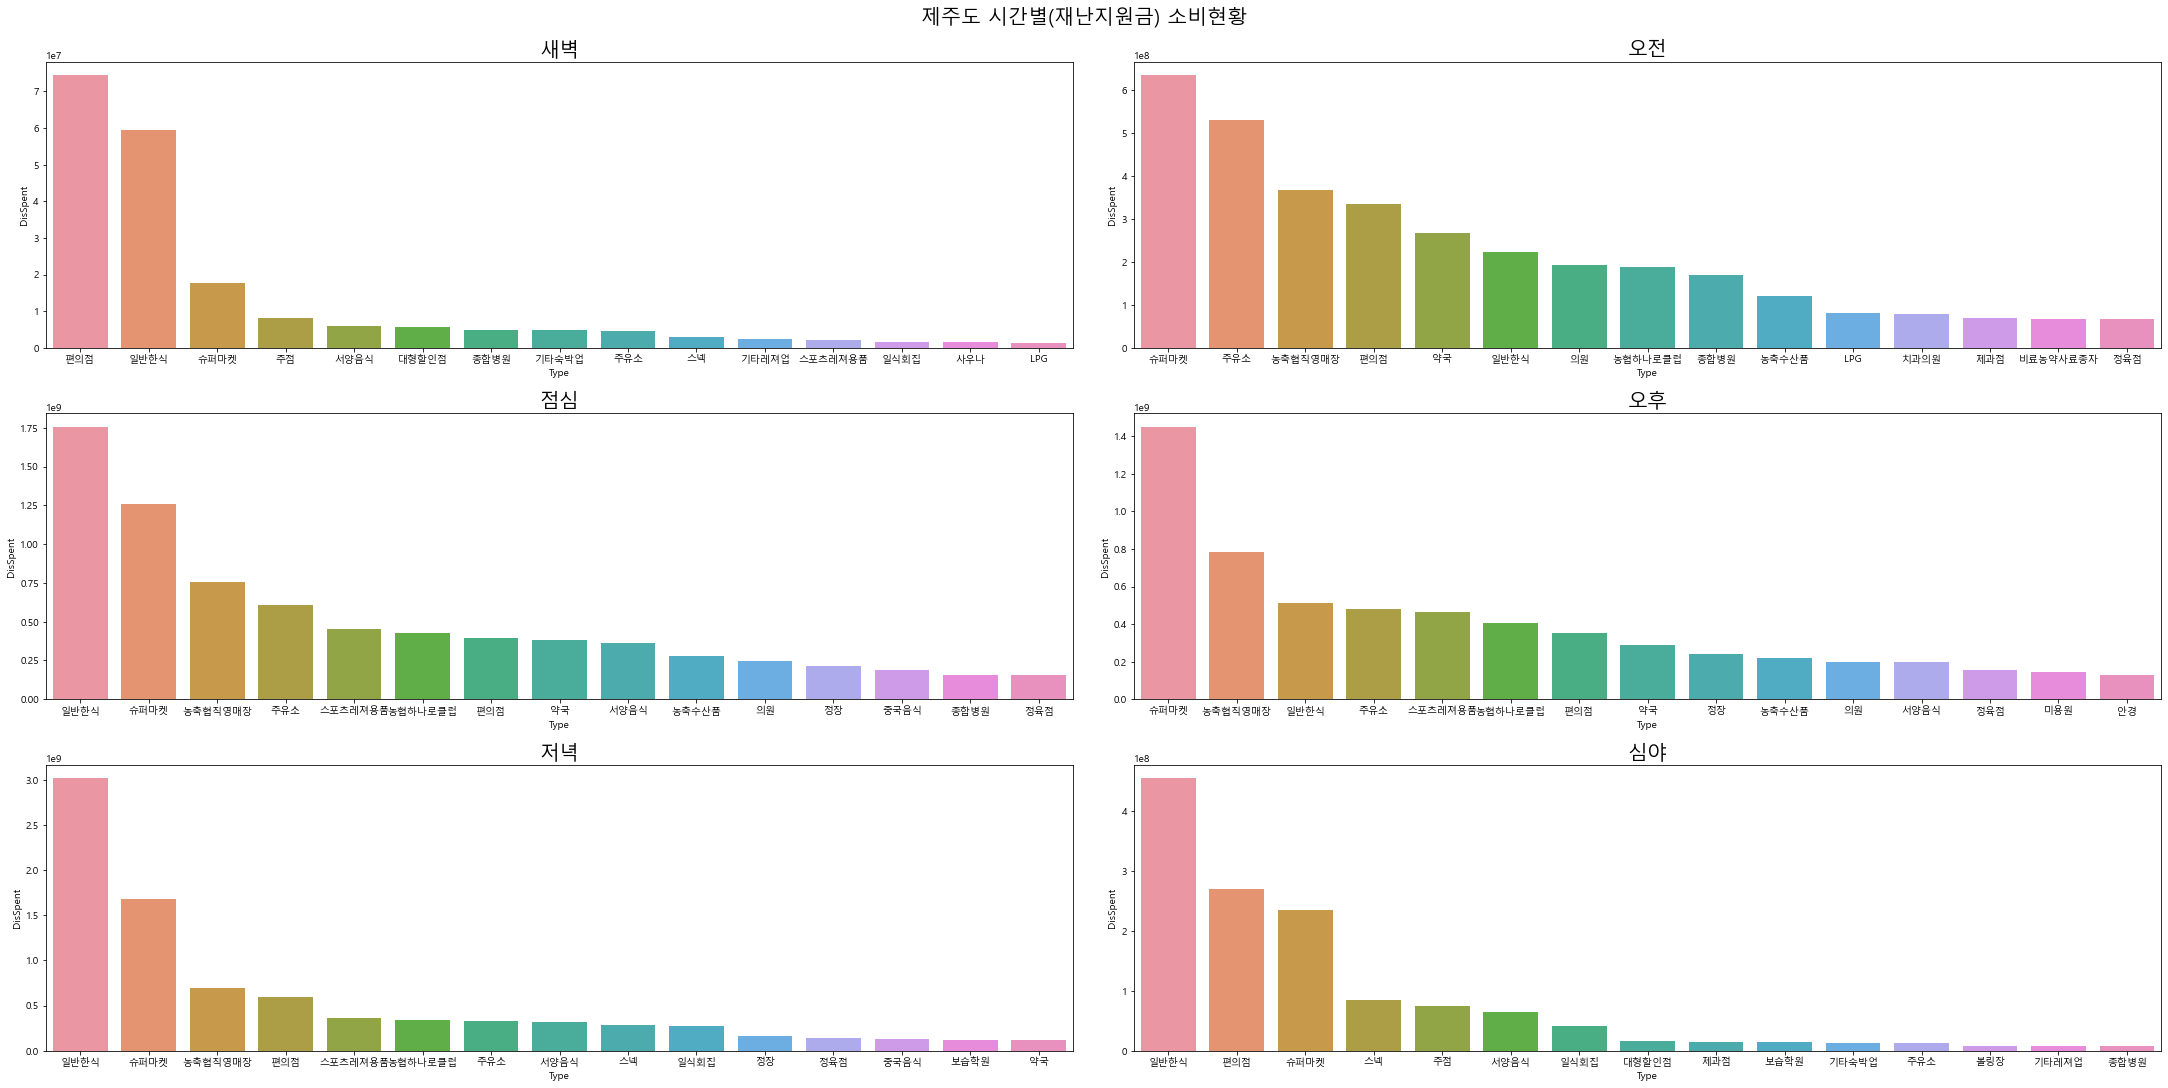

In [12]:
df_total_graph=[]
for i in list(('새벽', '오전', '점심', '오후', '저녁', '심야')):
           
    df_temp= jeju_all.groupby(['Time_cut','Type'])['DisSpent'].sum()
    df_temp=pd.DataFrame(df_temp).sort_values('DisSpent', ascending=False)
    df_temp.reset_index(inplace=True)
    df_total_graph.append(df_temp[df_temp['Time_cut']==i].reset_index(drop=True).head(15))

    
df_graph = pd.concat(df_total_graph, axis=0)
figure, ((ax1,ax2), (ax3,ax4),(ax5,ax6)) = plt.subplots(nrows=3, ncols=2, constrained_layout=True)
figure.set_size_inches(30,15)

sns.barplot(data=df_graph[df_graph['Time_cut']=='새벽'], x="Type", y="DisSpent", ax=ax1)  
sns.barplot(data=df_graph[df_graph['Time_cut']=='오전'],  x="Type", y="DisSpent", ax=ax2)  
sns.barplot(data=df_graph[df_graph['Time_cut']=='점심'],  x="Type", y="DisSpent", ax=ax3) 
sns.barplot(data=df_graph[df_graph['Time_cut']=='오후'],  x="Type",y="DisSpent", ax=ax4)  
sns.barplot(data=df_graph[df_graph['Time_cut']=='저녁'],  x="Type", y="DisSpent", ax=ax5)  
sns.barplot(data=df_graph[df_graph['Time_cut']=='심야'],  x="Type", y="DisSpent", ax=ax6)

ax1.set_title("새벽", fontsize=20)
ax2.set_title("오전", fontsize=20)
ax3.set_title("점심", fontsize=20)
ax4.set_title("오후", fontsize=20)
ax5.set_title("저녁", fontsize=20)
ax6.set_title("심야", fontsize=20)
plt.suptitle('제주도 시간별(재난지원금) 소비현황' ,fontsize=20)

#### 제주도에서 시간별로 재난지원금 사용행태를 업종으로 살펴보면
* 재난지원금을 사용할 수 없는 면세점, 대형마트, 유흥주점을 제외하면 총사용금액과 유사한 소비행태를 보입니다.
* 전 시간대에 슈퍼마켓, 농협하나로클럽, 편의점 등 생활밀착형 업종에서 재난지원금이 많이 사용됩니다.

### 3-2) 제주시/서귀포시 총 사용금액 비교

In [13]:
def df_time(a,b,c):
    """a는 제주시 or 서귀포시 하나를 입력
    b는 DisSpent or TotalSpent
    c는 시간을 문자열로"""
    df_temp= jeju_all[jeju_all['SIGUNGU']==a].groupby(['Time','Type'])[b].sum()
    df_temp=pd.DataFrame(df_temp).sort_values(b, ascending=False)
    df_temp.reset_index(inplace=True)
    return df_temp[df_temp['Time']==c].reset_index().head(10)

#### 제주시(시간별 소비 상위 10개 업종)

In [14]:
# 전체 시간별, 제주시 업종별 상위 10개 총사용금액을 보여줌(총사용금액)
df_total=[]
for i in range(24):
    if i < 10:
        i= '0'+ str(i)
        df_temp = df_time('제주시', 'TotalSpent', i )
        df_total.append(df_temp)
    else:
        df_temp = df_time('제주시', 'TotalSpent', str(i))
        df_total.append(df_temp)

pd.options.display.max_columns = len(pd.concat(df_total, axis=1).drop(['index'], axis=1).columns)    
pd.concat(df_total, axis=1).drop(['index'], axis=1)

Time     Type  TotalSpent Time     Type  TotalSpent Time     Type  \
0   00     일반한식  1407801782   01     일반한식   901702835   02     유흥주점   
1   00     유흥주점   929235134   01     유흥주점   859121591   02     일반한식   
2   00      편의점   801763750   01     단란주점   601556518   02     단란주점   
3   00     단란주점   655288940   01      편의점   518121921   02      편의점   
4   00       주점   399844313   01       주점   266667194   02       주점   
5   00     서양음식   252106710   01     서양음식   165690430   02     서양음식   
6   00  인터넷Mall   240513708   01  인터넷Mall   134106140   02    기타숙박업   
7   00      항공사   207568300   01      항공사   101958200   02     슈퍼마켓   
8   00       스넥   152995717   01     슈퍼마켓    91904839   02     칵테일바   
9   00    기타숙박업   139421044   01    기타숙박업    86827008   02  인터넷Mall   

   TotalSpent Time   Type  TotalSpent Time   Type  TotalSpent Time     Type  \
0   688764033   03   유흥주점   479139740   04   유흥주점   280344200   05      편의점   
1   588921004   03   일반한식   374921560   04   일반한식   198593723   05     유흥주점   
2   415872700   03    편의점   244301900   04    편의점   192252569   05     일반한식   
3   351621358   03   단란주점   175273567   04    주유소    67770498   05      주유소   
4   157748150   03     주점    68931917   04   단란주점    61494600   05     슈퍼마켓   
5    92690990   03   슈퍼마켓    51316040   04   슈퍼마켓    44333930   05     단란주점   
6    66801708   03   서양음식    51104390   04     주점    34965550   05    기타숙박업   
7    66418500   03  기타숙박업    51077137   04  기타숙박업    34391285   05  인터넷Mall   
8    65451500   03    주유소    37352377   04   칵테일바    23464000   05      사우나   
9    51352731   03   칵테일바    32644500   04   종합병원    19771020   05      항공사   

   TotalSpent Time   Type  TotalSpent Time    Type  TotalSpent Time    Type  \
0   268270250   06    편의점   543819058   07     면세점  1046321630   08     면세점   
1   168783700   06    주유소   485398650   07     주유소   989042044   08     주유소   
2   145814640   06    면세점   374407590   07     편의점   858303420   08    슈퍼마켓   
3   124323044   06   일반한식   234842688   07    슈퍼마켓   535214330   08     편의점   
4    73631960   06   슈퍼마켓   175002290   07    일반한식   392307441   08    일반한식   
5    26316100   06  골프경기장   162541240   07   골프경기장   266200742   08     유아원   
6    25634397   06   화물운송   115288840   07  기타건축자재   154535232   08     렌트카   
7    24885807   06   유흥주점    87957050   07     유아원   134468830   08    종합병원   
8    21426500   06   특급호텔    48636903   07   농축수산품   128555660   08   농축수산품   
9    21371400   06    항공사    46905000   07     LPG   105797586   08  기타건축자재   

   TotalSpent Time     Type  TotalSpent Time  Type  TotalSpent Time  Type  \
0  1355853960   09      유아원  1870278720   10   유아원  2075022350   11  일반한식   
1  1339859731   09      면세점  1689285439   10  슈퍼마켓  1998628582   11   면세점   
2   981474048   09     슈퍼마켓  1631347143   10   면세점  1943990435   11  슈퍼마켓   
3   967745290   09      주유소  1557477186   10  일반한식  1905421039   11   주유소   
4   616994529   09       약국  1149124957   10   주유소  1656503444   11   유아원   
5   583405690   09     일반한식  1121797105   10  종합병원  1624209070   11  종합병원   
6   424367835   09     종합병원   981002920   10    약국  1403301953   11    약국   
7   412144620   09       의원   971633270   10    의원  1362345894   11    의원   
8   308531807   09      편의점   902763630   10   편의점   932247070   11  서양음식   
9   293200912   09  농협하나로클럽   559769100   10  치과의원   755011116   11   편의점   

   TotalSpent Time   Type  TotalSpent Time   Type  TotalSpent Time     Type  \
0  3954555083   12   일반한식  9221923097   13   일반한식  7032846076   14     일반한식   
1  2112373240   12    면세점  2579277960   13    면세점  2446405193   14      면세점   
2  2021154729   12   슈퍼마켓  2056531844   13   슈퍼마켓  2229145753   14     슈퍼마켓   
3  1680136102   12   서양음식  1904271135   13   서양음식  1906939763   14      주유소   
4  1610329700   12    주유소  1625505222   13    주유소  1739621121   14     서양음식   
5  1410255711   12  골프경기장  1428912388   13    유아원  1432348840   14      유아원   
6  1386428186   12    유아원  1359970940   13    편의점  1240630600   14      편의점   


#### 서귀포시(시간별 소비 상위 10개 업종)

In [15]:
# 전체 시간별, 서귀포시 업종별 상위 10개 총사용금액을 보여줌(총사용금액)
df_total=[]
for i in range(24):
    if i < 10:
        i= '0'+ str(i)
        df_temp = df_time('서귀포시', 'TotalSpent', i )
        df_total.append(df_temp)
    else:
        df_temp = df_time('서귀포시', 'TotalSpent', str(i))
        df_total.append(df_temp)

pd.options.display.max_columns = len(pd.concat(df_total, axis=1).drop(['index'], axis=1).columns)    
pd.concat(df_total, axis=1).drop(['index'], axis=1)

Time   Type  TotalSpent Time   Type  TotalSpent Time   Type  TotalSpent  \
0   00   유흥주점   448084700   01   유흥주점   390357700   02   유흥주점   318545010   
1   00   일반한식   270162664   01   일반한식   165933896   02    편의점   108758460   
2   00    편의점   268004811   01    편의점   161737330   02   단란주점    98219010   
3   00   단란주점   174926000   01   단란주점   147725113   02   일반한식    89971516   
4   00     주점   109917060   01     주점    75097340   02     주점    45149136   
5   00   서양음식    69256950   01   서양음식    32899740   02     콘도    20585297   
6   00     스넥    56404905   01  기타숙박업    25139222   02  기타숙박업    20349245   
7   00  기타숙박업    40934196   01     스넥    19981300   02   서양음식    16121840   
8   00   일식회집    36040200   01   일식회집    15627400   02     스넥     7939300   
9   00    노래방    18274700   01    유아원    10305600   02   종합병원     4645250   

  Time   Type  TotalSpent Time     Type  TotalSpent Time     Type  TotalSpent  \
0   03   유흥주점   174018308   04     유흥주점    98658870   05      편의점    93361910   
1   03    편의점    73049310   04      편의점    60448620   05       콘도    41427954   
2   03   일반한식    60760400   04       콘도    38188611   05     유흥주점    36252710   
3   03   단란주점    46428000   04     일반한식    35250100   05     일반한식    24851021   
4   03     콘도    28122956   04     단란주점    22985000   05      주유소    23715370   
5   03     주점    17031000   04    기타숙박업     9211520   05     단란주점    16315000   
6   03  기타숙박업    10045179   04       주점     8246200   05  스포츠레져용품    12894800   
7   03   특급호텔     8203676   04  스포츠레져용품     4120000   05    골프경기장    11044580   
8   03   서양음식     7231500   04      유아원     3517250   05    기타숙박업    10066548   
9   03   칵테일바     4439900   04     종합병원     3232010   05     슈퍼마켓     9243970   

  Time     Type  TotalSpent Time     Type  TotalSpent Time     Type  \
0   06      편의점   203831140   07      주유소   444586068   08      주유소   
1   06      주유소   199031684   07      편의점   325691510   08     슈퍼마켓   
2   06    골프경기장   166322620   07     슈퍼마켓   230862660   08      편의점   
3   06     슈퍼마켓    74944060   07    골프경기장   220525651   08       콘도   
4   06       콘도    58520649   07     일반한식   123541040   08  농축협직영매장   
5   06     일반한식    47694900   07       콘도   114769080   08     일반한식   
6   06     유흥주점    18550500   07      유아원    61287990   08      유아원   
7   06  스포츠레져용품    18242200   07     서양음식    54278838   08     특급호텔   
8   06    기타숙박업    14450259   07  농축협직영매장    52999482   08    골프경기장   
9   06     특급호텔    13439591   07     특급호텔    48355235   08     서양음식   

   TotalSpent Time     Type  TotalSpent Time     Type  TotalSpent Time  \
0   627665541   09      주유소   729050596   10       콘도   827864238   11   
1   407069987   09     슈퍼마켓   634314775   10      주유소   776933842   11   
2   392393370   09      유아원   610415050   10     특급호텔   739324647   11   
3   250740236   09       콘도   504106218   10     슈퍼마켓   725408487   11   
4   246258410   09  농축협직영매장   465774964   10     일반한식   654374524   11   
5   233818870   09     일반한식   429078280   10  농축협직영매장   638125868   11   
6   215046920   09      편의점   381238690   10      유아원   610780730   11   
7   123223431   09     특급호텔   303269509   10      편의점   390304320   11   
8   117891277   09    농축수산품   199549224   10     서양음식   336951241   11   
9   102655021   09       약국   196505527   10    골프경기장   278780470   11   

      Type  TotalSpent Time     Type  TotalSpent Time     Type  TotalSpent  \
0     일반한식  1619380378   12     일반한식  3763534901   13     일반한식  3065013500   
1     특급호텔   927546983   12     서양음식   962273638   13     서양음식  1016698110   
2       콘도   820067078   12    골프경기장   862993200   13     슈퍼마켓   811497724   
3      주유소   793563588   12     슈퍼마켓   781607175   13      주유소   767414373   
4     슈퍼마켓   739132333   12      주유소   730790444   13    골프경기장   765996718   
5    골프경기장   665970532   12      편의점   520559170   13  농축협직영매장   610617919   
6  농축협직영매장   603395186   12  농축협직영매장   511262292   13      편의점   496573454   
7     서양음식   585960365   12    농축수산품   48

#### 제주시 시간대별 소비 상위 10개업종 시각화

Text(0.5, 0.98, '제주시 시간별 소비현황')

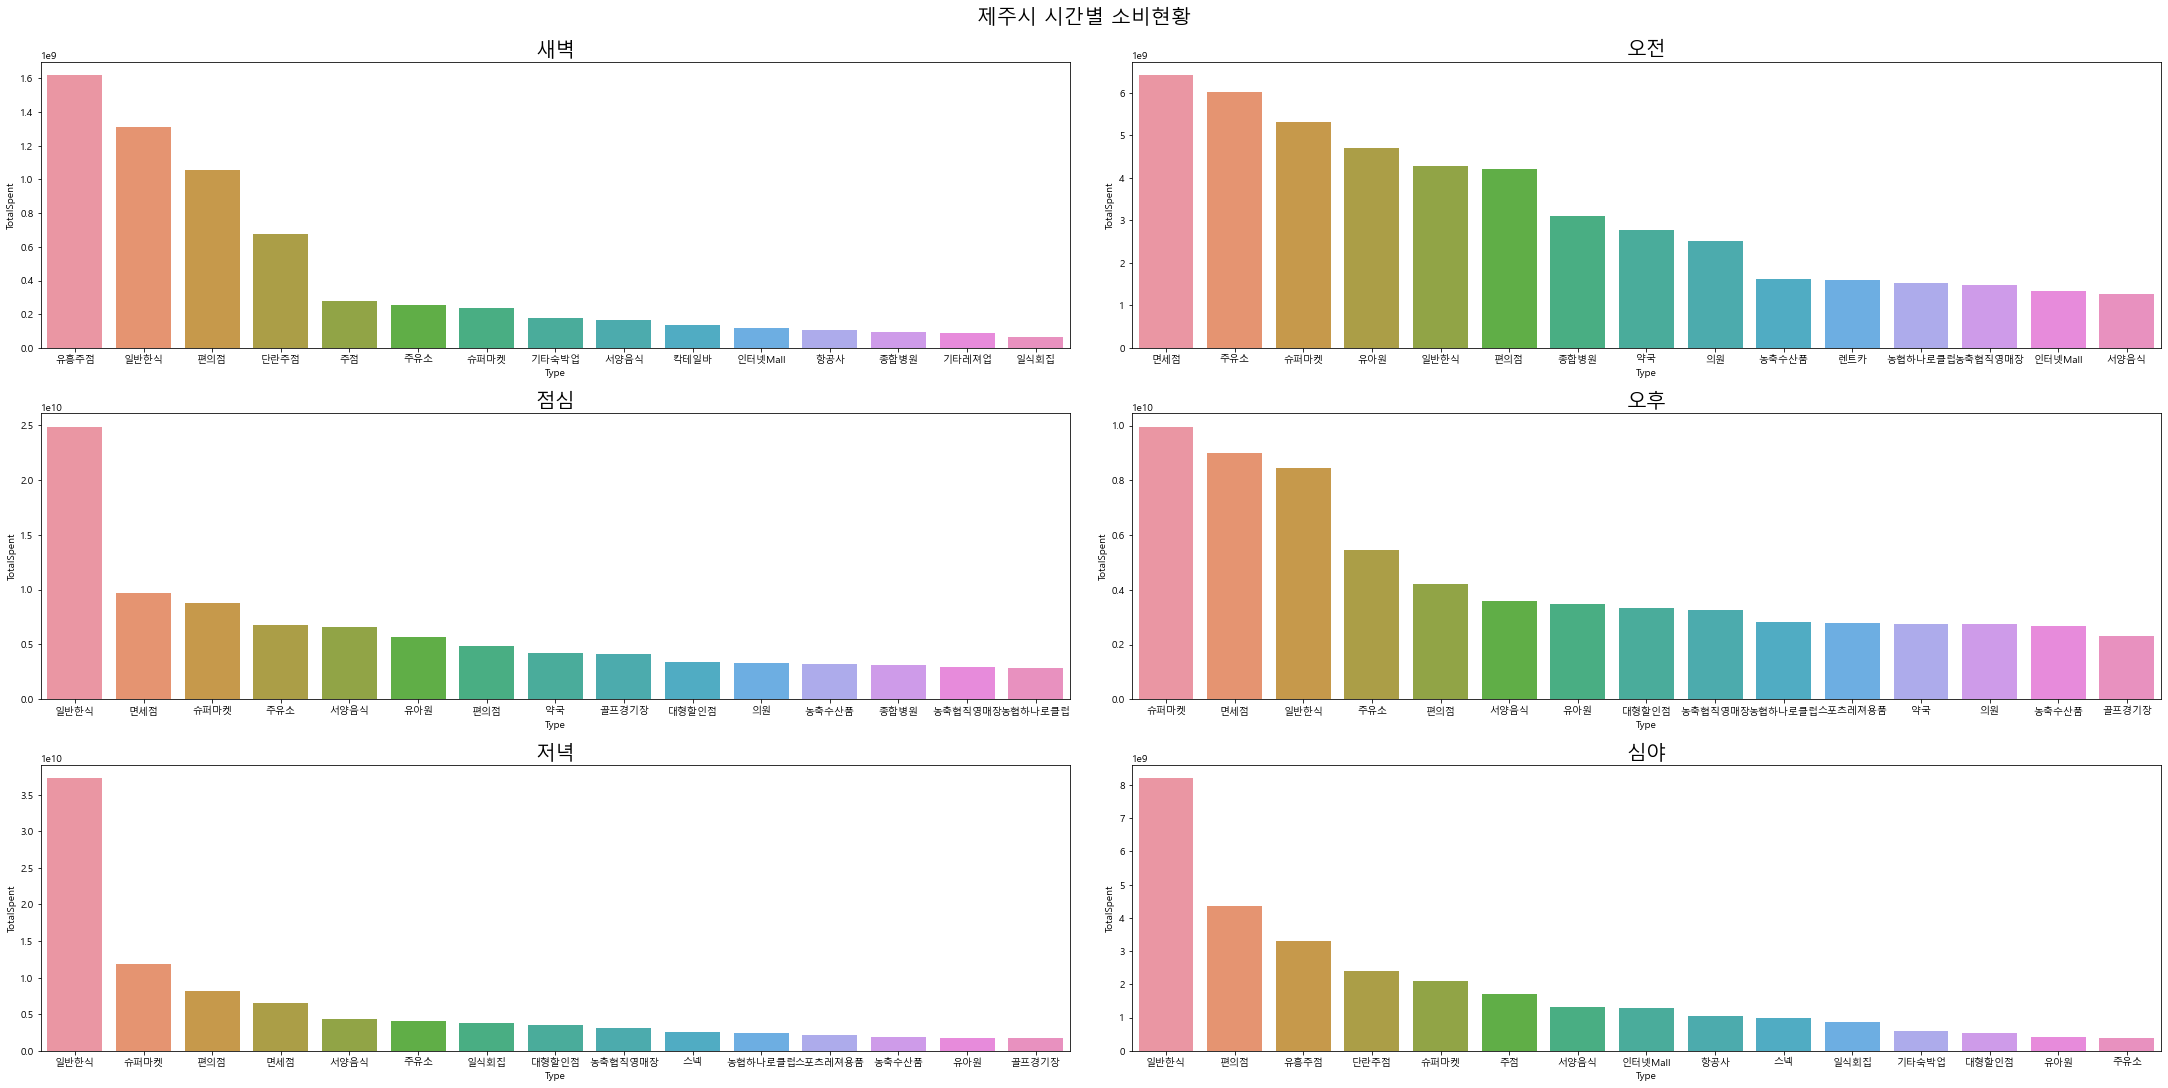

In [16]:
df_total_graph=[]
for i in list(('새벽', '오전', '점심', '오후', '저녁', '심야')):
           
    df_temp= jeju_all[jeju_all['SIGUNGU']=='제주시'].groupby(['Time_cut','Type'])['TotalSpent'].sum()
    df_temp=pd.DataFrame(df_temp).sort_values('TotalSpent', ascending=False)
    df_temp.reset_index(inplace=True)
    df_total_graph.append(df_temp[df_temp['Time_cut']==i].reset_index(drop=True).head(15))

    
df_graph = pd.concat(df_total_graph, axis=0)
figure, ((ax1,ax2), (ax3,ax4),(ax5,ax6)) = plt.subplots(nrows=3, ncols=2, constrained_layout=True)
figure.set_size_inches(30,15)

sns.barplot(data=df_graph[df_graph['Time_cut']=='새벽'], x="Type", y="TotalSpent", ax=ax1)  
sns.barplot(data=df_graph[df_graph['Time_cut']=='오전'],  x="Type", y="TotalSpent", ax=ax2)  
sns.barplot(data=df_graph[df_graph['Time_cut']=='점심'],  x="Type", y="TotalSpent", ax=ax3) 
sns.barplot(data=df_graph[df_graph['Time_cut']=='오후'],  x="Type",y="TotalSpent", ax=ax4)  
sns.barplot(data=df_graph[df_graph['Time_cut']=='저녁'],  x="Type", y="TotalSpent", ax=ax5)  
sns.barplot(data=df_graph[df_graph['Time_cut']=='심야'],  x="Type", y="TotalSpent", ax=ax6)

ax1.set_title("새벽", fontsize=20)
ax2.set_title("오전", fontsize=20)
ax3.set_title("점심", fontsize=20)
ax4.set_title("오후", fontsize=20)
ax5.set_title("저녁", fontsize=20)
ax6.set_title("심야", fontsize=20)
plt.suptitle('제주시 시간별 소비현황' ,fontsize=20)

#### 서귀포시 시간대별 소비 상위 10개업종 시각화

Text(0.5, 0.98, '서귀포시 시간별 소비현황')

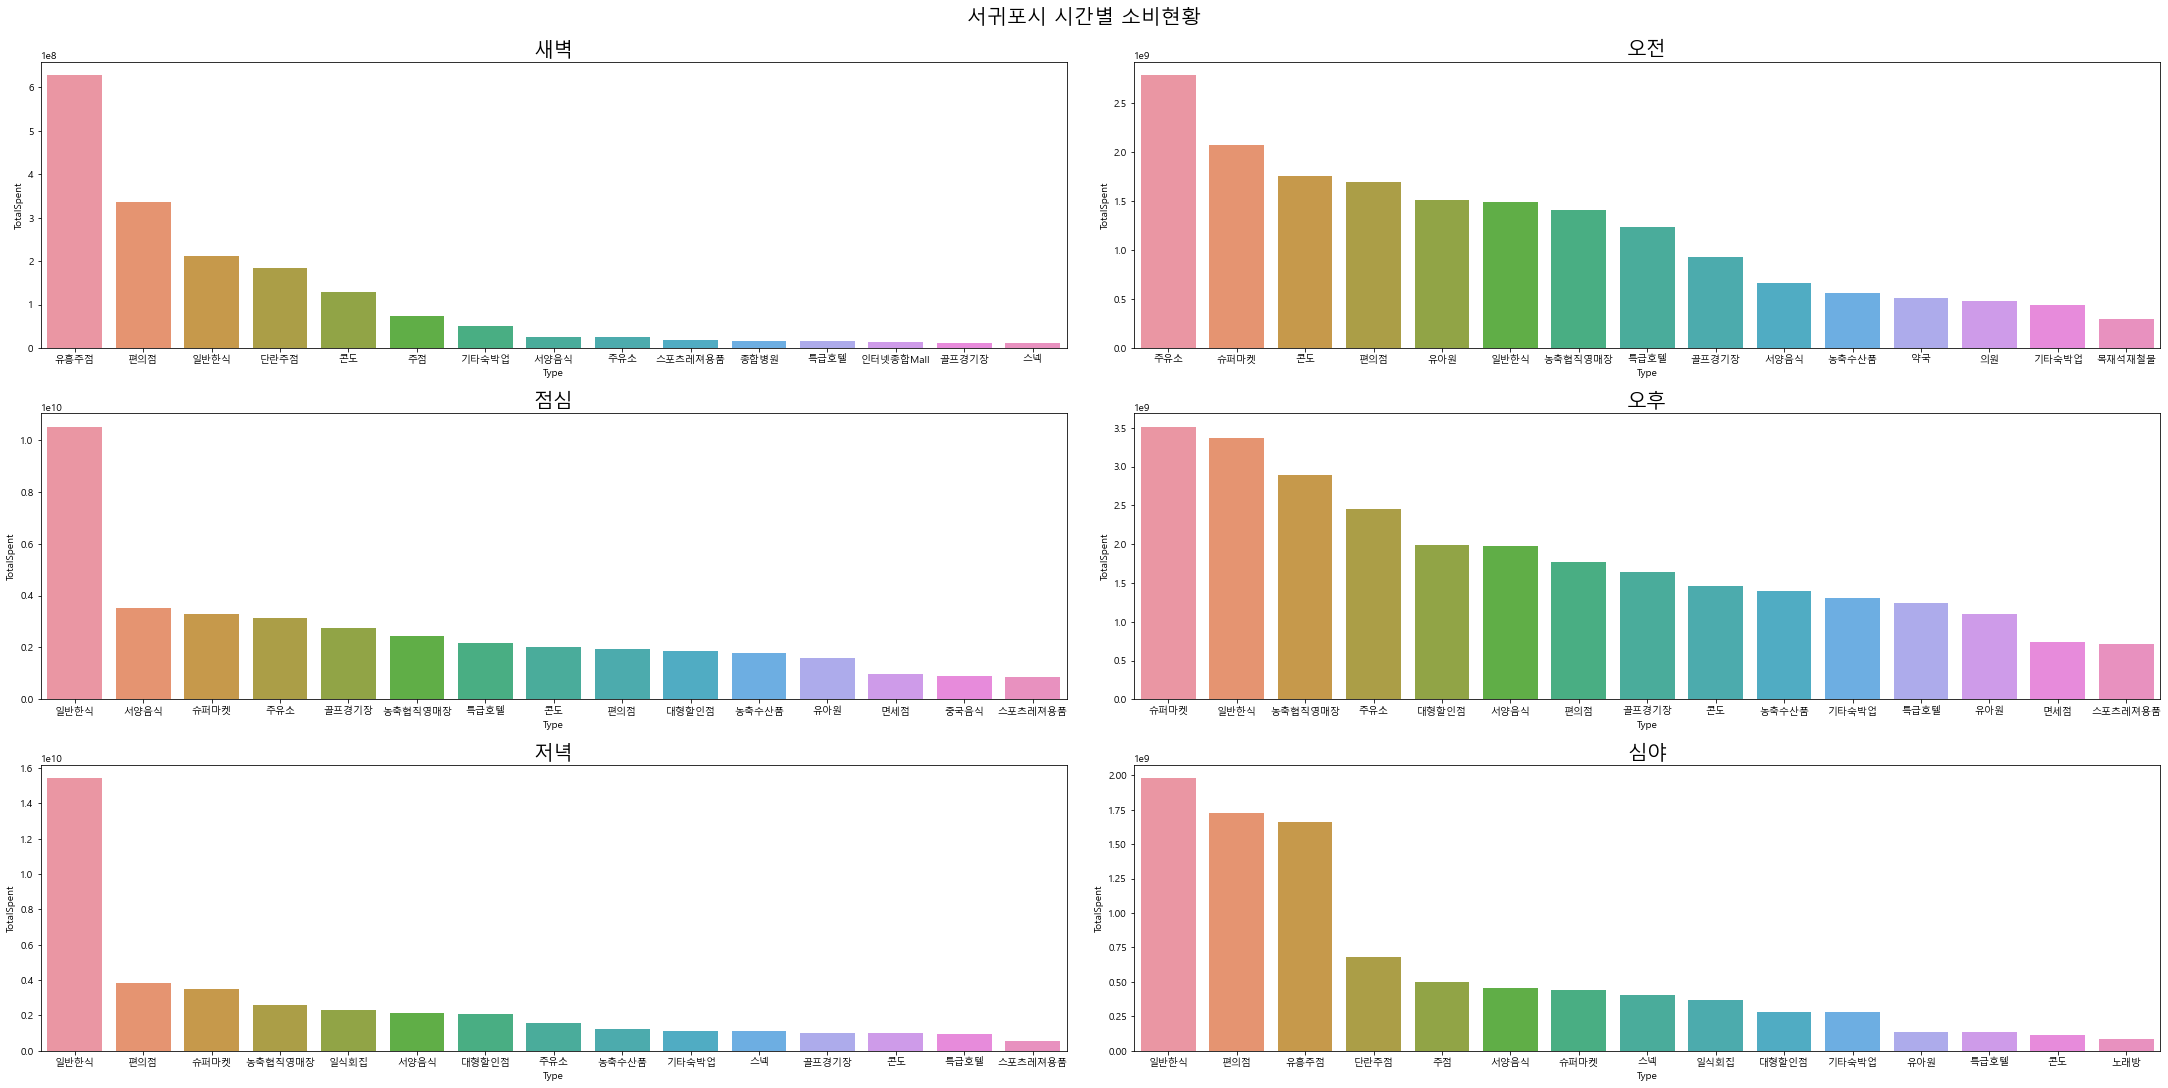

In [17]:
df_total_graph=[]
for i in list(('새벽', '오전', '점심', '오후', '저녁', '심야')):
           
    df_temp= jeju_all[jeju_all['SIGUNGU']=='서귀포시'].groupby(['Time_cut','Type'])['TotalSpent'].sum()
    df_temp=pd.DataFrame(df_temp).sort_values('TotalSpent', ascending=False)
    df_temp.reset_index(inplace=True)
    df_total_graph.append(df_temp[df_temp['Time_cut']==i].reset_index(drop=True).head(15))

    
df_graph = pd.concat(df_total_graph, axis=0)
figure, ((ax1,ax2), (ax3,ax4),(ax5,ax6)) = plt.subplots(nrows=3, ncols=2, constrained_layout=True)
figure.set_size_inches(30,15)

sns.barplot(data=df_graph[df_graph['Time_cut']=='새벽'], x="Type", y="TotalSpent", ax=ax1)  
sns.barplot(data=df_graph[df_graph['Time_cut']=='오전'],  x="Type", y="TotalSpent", ax=ax2)  
sns.barplot(data=df_graph[df_graph['Time_cut']=='점심'],  x="Type", y="TotalSpent", ax=ax3) 
sns.barplot(data=df_graph[df_graph['Time_cut']=='오후'],  x="Type",y="TotalSpent", ax=ax4)  
sns.barplot(data=df_graph[df_graph['Time_cut']=='저녁'],  x="Type", y="TotalSpent", ax=ax5)  
sns.barplot(data=df_graph[df_graph['Time_cut']=='심야'],  x="Type", y="TotalSpent", ax=ax6)

ax1.set_title("새벽", fontsize=20)
ax2.set_title("오전", fontsize=20)
ax3.set_title("점심", fontsize=20)
ax4.set_title("오후", fontsize=20)
ax5.set_title("저녁", fontsize=20)
ax6.set_title("심야", fontsize=20)
plt.suptitle('서귀포시 시간별 소비현황' ,fontsize=20)

#### 제주시와 서귀포시의 시간별 총 사용금액을 업종별로 비교해보면
* 제주시와 서귀포시에서 공통적으로 일반한식, 슈퍼마켓 등 생활소비업종에서 소비가 높은 것을 볼 수 있습니다.
* 제주시는 면세점이 총 소비의 상위권을 차지하고 있으며 종합병원과 의원, 약국이 높은 것으로 보아 주거 밀집지역임을 생각해 볼 수 있습니다.
* 서귀포시는 콘도, 골프경기장, 특급호텔에서의 소비가 높은 것으로 보아 관광지임을 생각해 볼 수 있습니다.

## 4) 업종별 시간대 사용금액/이용건수 추이 분석.

시간대에 따라 이용건수의 분포가 명확하게 나타날 것으로 생각한 유통/판매 및 외식업종을 기준으로 시각화 및 분석하였습니다. 

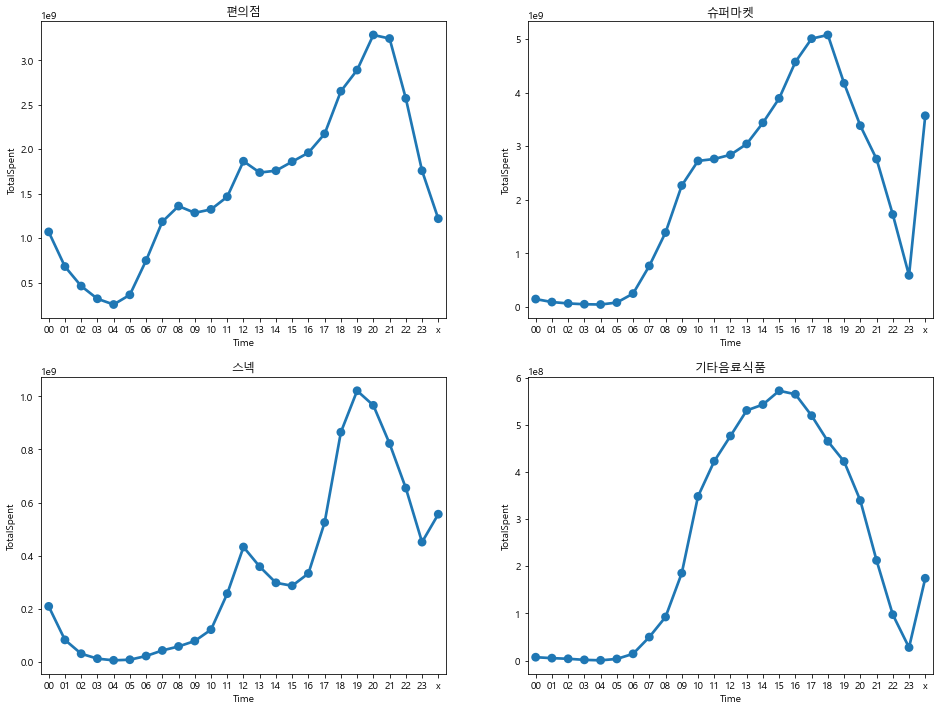

In [23]:
# 식음료 판매 업종 4가지의 시간대별 총 사용 금액

fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(2, 2, 1)
ax1 = sns.pointplot(x='Time', y='TotalSpent', data=jeju_all[(jeju_all['Type'] == '편의점')].groupby(['Type', 'Time'])['TotalSpent'].sum().reset_index())
ax1.set_title('편의점')
ax2 = fig.add_subplot(2, 2, 2)
ax2 = sns.pointplot(x='Time', y='TotalSpent', data=jeju_all[(jeju_all['Type'] == '슈퍼마켓')].groupby(['Type', 'Time'])['TotalSpent'].sum().reset_index())
ax2.set_title('슈퍼마켓')
ax3 = fig.add_subplot(2, 2, 3)
ax3 = sns.pointplot(x='Time', y='TotalSpent', data=jeju_all[(jeju_all['Type'] == '스넥')].groupby(['Type', 'Time'])['TotalSpent'].sum().reset_index())
ax3.set_title('스넥')
ax4 = fig.add_subplot(2, 2, 4)
ax4 = sns.pointplot(x='Time', y='TotalSpent', data=jeju_all[(jeju_all['Type'] == '기타음료식품')].groupby(['Type', 'Time'])['TotalSpent'].sum().reset_index())
ax4.set_title('기타음료식품')
plt.show()

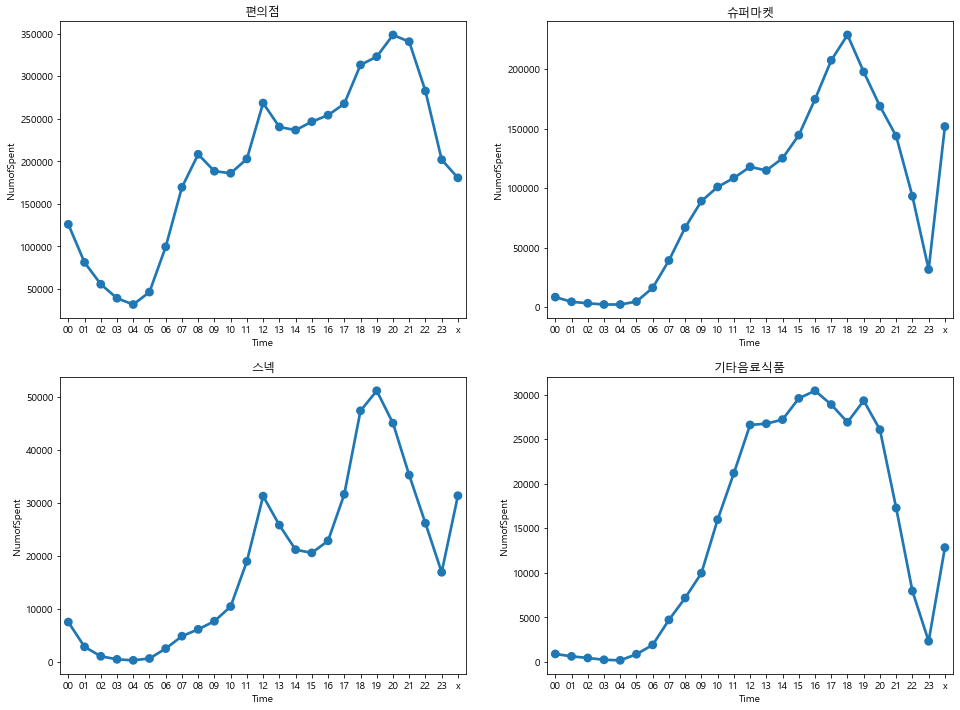

In [24]:
# 식음료 판매 업종 4가지의 시간대별 이용건수
fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(2, 2, 1)
ax1 = sns.pointplot(x='Time', y='NumofSpent', data=jeju_all[(jeju_all['Type'] == '편의점')].groupby(['Type', 'Time'])['NumofSpent'].sum().reset_index())
ax1.set_title('편의점')
ax2 = fig.add_subplot(2, 2, 2)
ax2 = sns.pointplot(x='Time', y='NumofSpent', data=jeju_all[(jeju_all['Type'] == '슈퍼마켓')].groupby(['Type', 'Time'])['NumofSpent'].sum().reset_index())
ax2.set_title('슈퍼마켓')
ax3 = fig.add_subplot(2, 2, 3)
ax3 = sns.pointplot(x='Time', y='NumofSpent', data=jeju_all[(jeju_all['Type'] == '스넥')].groupby(['Type', 'Time'])['NumofSpent'].sum().reset_index())
ax3.set_title('스넥')
ax4 = fig.add_subplot(2, 2, 4)
ax4 = sns.pointplot(x='Time', y='NumofSpent', data=jeju_all[(jeju_all['Type'] == '기타음료식품')].groupby(['Type', 'Time'])['NumofSpent'].sum().reset_index())
ax4.set_title('기타음료식품')
plt.show()

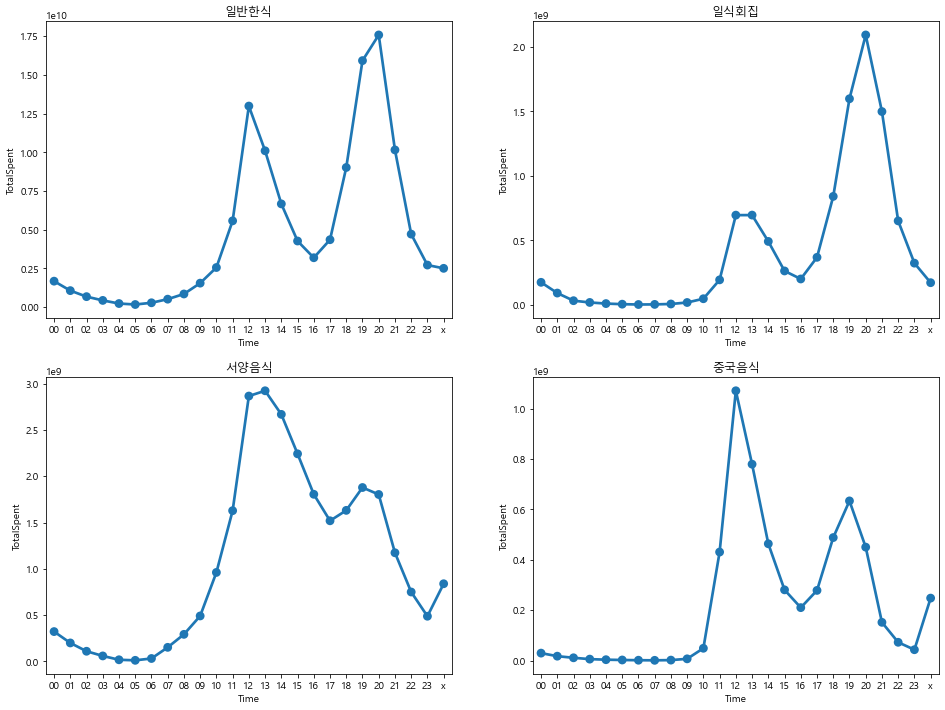

In [25]:
# 외식업종으로 분류된 업종 4가지의 시간대별 총 사용 금액

fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(2, 2, 1)
ax1 = sns.pointplot(x='Time', y='TotalSpent', data=jeju_all[(jeju_all['Type'] == '일반한식')].groupby(['Type', 'Time'])['TotalSpent'].sum().reset_index())
ax1.set_title('일반한식')
ax2 = fig.add_subplot(2, 2, 2)
ax2 = sns.pointplot(x='Time', y='TotalSpent', data=jeju_all[(jeju_all['Type'] == '일식회집')].groupby(['Type', 'Time'])['TotalSpent'].sum().reset_index())
ax2.set_title('일식회집')
ax3 = fig.add_subplot(2, 2, 3)
ax3 = sns.pointplot(x='Time', y='TotalSpent', data=jeju_all[(jeju_all['Type'] == '서양음식')].groupby(['Type', 'Time'])['TotalSpent'].sum().reset_index())
ax3.set_title('서양음식')
ax4 = fig.add_subplot(2, 2, 4)
ax4 = sns.pointplot(x='Time', y='TotalSpent', data=jeju_all[(jeju_all['Type'] == '중국음식')].groupby(['Type', 'Time'])['TotalSpent'].sum().reset_index())
ax4.set_title('중국음식')
plt.show()

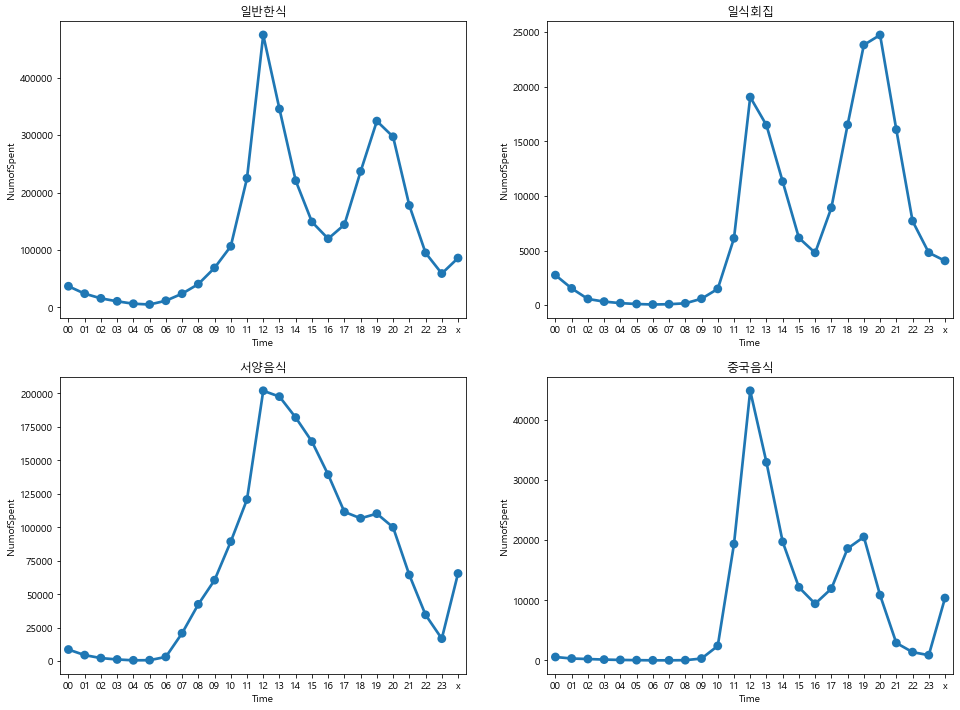

In [26]:
# 외식업종으로 분류된 업종 4가지의 시간대별 이용건수

fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(2, 2, 1)
ax1 = sns.pointplot(x='Time', y='NumofSpent', data=jeju_all[(jeju_all['Type'] == '일반한식')].groupby(['Type', 'Time'])['NumofSpent'].sum().reset_index())
ax1.set_title('일반한식')
ax2 = fig.add_subplot(2, 2, 2)
ax2 = sns.pointplot(x='Time', y='NumofSpent', data=jeju_all[(jeju_all['Type'] == '일식회집')].groupby(['Type', 'Time'])['NumofSpent'].sum().reset_index())
ax2.set_title('일식회집')
ax3 = fig.add_subplot(2, 2, 3)
ax3 = sns.pointplot(x='Time', y='NumofSpent', data=jeju_all[(jeju_all['Type'] == '서양음식')].groupby(['Type', 'Time'])['NumofSpent'].sum().reset_index())
ax3.set_title('서양음식')
ax4 = fig.add_subplot(2, 2, 4)
ax4 = sns.pointplot(x='Time', y='NumofSpent', data=jeju_all[(jeju_all['Type'] == '중국음식')].groupby(['Type', 'Time'])['NumofSpent'].sum().reset_index())
ax4.set_title('중국음식')
plt.show()

#### 먹거리 업종의 시간대별 이용 현황
- 전체적으로 보았을 때 총 이용 건수가 많다고 하더라도 총 사용 금액이 똑같이 높아지지 않는 것으로 보입니다.
- 식음료 판매 업종들은 유사한 시간대에 소비가 이루어지지만 '기타음료식품'의 경우 뚜렷하게 많이 이용되고 있는 시간대가 있는 것을 보여줍니다. (11시~20시)
- 음식 종류로 분류된 업종은 뚜렷하게 점심 시간(12시)과 저녁 시간(18-19시)인 것으로 나타납니다..

In [ ]:
###################################################################

## 5) 지역별 소비분석.


- 지역별 상위 5개 업종 타입 
- 지역별 시간대 사용금액 확인 

### 5-1) 지역별 업종 규모 분포 확인 및 시각화 

In [19]:
############# 지역별 업종 규모 분포 ##############

df_js2 = jeju_all[jeju_all['FranClass']=='중소2'] #중소2에 대해 추출 
df_js2 = df_js2[['SIGUNGU','FranClass','Type','lon','lat','lon_lat']] #업종별 분포 확인에 대한 정보만 추출 
df_js2.drop_duplicates(inplace=True) #중복되는 row 삭제 
df_js2 #중소2 업종 리스트 

df_js1 = jeju_all[jeju_all['FranClass']=='중소1'] #중소1에 대해 추출 
df_js1 = df_js1[['SIGUNGU','FranClass','Type','lon','lat','lon_lat']] #업종별 분포 확인에 대한 정보만 추출 
df_js1.drop_duplicates(inplace=True) #중복되는 row 삭제 
df_js1 #중소1 업종 리스트 

df_js = jeju_all[jeju_all['FranClass']=='중소'] #중소에 대해 추출 
df_js = df_js[['SIGUNGU','FranClass','Type','lon','lat','lon_lat']] #업종별 분포 확인에 대한 정보만 추출 
df_js.drop_duplicates(inplace=True) #중복되는 row 삭제 
df_js #중소 업종 리스트 

df_gn = jeju_all[jeju_all['FranClass']=='일반'] #일반에 대해 추출 
df_gn = df_gn[['SIGUNGU','FranClass','Type','lon','lat','lon_lat']] #업종별 분포 확인에 대한 정보만 추출 
df_gn.drop_duplicates(inplace=True) #중복되는 row 삭제 
df_gn #일반 업종 리스트 

df_ys = jeju_all[jeju_all['FranClass']=='영세'] #중소에 대해 추출 
df_ys = df_ys[['SIGUNGU','FranClass','Type','lon','lat','lon_lat']] #업종별 분포 확인에 대한 정보만 추출 
df_ys.drop_duplicates(inplace=True) #중복되는 row 삭제 
df_ys #중소 업종 리스트 

SIGUNGU FranClass       Type                 lon                 lat  \
0          제주시        영세       일반한식  126.17889362710162   33.30231529076243   
5          제주시        영세         의원  126.17889362710162   33.30231529076243   
26         제주시        영세       단란주점  126.17888426813494  33.302765922881875   
31         제주시        영세       일반한식  126.17888426813494  33.302765922881875   
45         제주시        영세   비료농약사료종자  126.17945834265305   33.30097125427593   
...        ...       ...        ...                 ...                 ...   
280063    서귀포시        영세      기타숙박업  126.83882456997848   33.37198974202468   
280068     제주시        영세       기타교육  126.29371775568167   33.44278262819118   
280073     제주시        영세       기타교육  126.44677192780091  33.483559882610706   
280078     제주시        영세      농축수산품   126.5292452740336  33.473746251556754   
280081     제주시        영세  학원(회원제형태)    126.535342658025    33.4950054416331   

                                      lon_lat  
0        126.17889362710162_33.30231529076243  
5        126.17889362710162_33.30231529076243  
26      126.17888426813494_33.302765922881875  
31      126.17888426813494_33.302765922881875  
45       126.17945834265305_33.30097125427593  
...                                       ...  
280063   126.83882456997848_33.37198974202468  
280068   126.29371775568167_33.44278262819118  
280073  126.44677192780091_33.483559882610706  
280078   126.5292452740336_33.473746251556754  
280081      126.535342658025_33.4950054416331  

[25132 rows x 6 columns]

In [ ]:
#############folium을 통한 표현############ 
#용량문제로 시각화 생략#
import pandas as pd 
import folium
from folium.plugins import MarkerCluster, MiniMap

map_jeju = folium.Map((33.38773221915759, 126.54124720118492), zoom_start= 13)
mc = MarkerCluster()

minimap = MiniMap()
map_jeju.add_child(minimap)

map_jeju.add_child(mc)


map = folium.Map((33.38773221915759, 126.54124720118492), zoom_start= 10)

# 중소2 서클 추가 
for i in range(len(df_js2['FranClass'])):
    folium.Circle(list(df_js2.iloc[i][['lat','lon']]), radius=1, color = '#e41a1c',fill_color = '#e41a1c').add_to(map)

# 중소1 서클 추가 
for i in range(len(df_js1['FranClass'])):
    folium.Circle(list(df_js1.iloc[i][['lat','lon']]), radius=1, color = '#377eb8',fill_color = '#d7b5d8').add_to(map)

# 중소 서클 추가 
for i in range(len(df_js['FranClass'])):
    folium.Circle(list(df_js.iloc[i][['lat','lon']]), radius=1, color = '#4daf4a',fill_color = '#df65b0').add_to(map)

# 일반 서클 추가 
for i in range(len(df_gn['FranClass'])):
    folium.Circle(list(df_gn.iloc[i][['lat','lon']]), radius=1, color = '#984ea3',fill_color = '#dd1c77').add_to(map)

# 영세 서클 추가 
for i in range(len(df_ys['FranClass'])):
    folium.Circle(list(df_ys.iloc[i][['lat','lon']]), radius=1, color = '#ff7f00',fill_color = '#980043').add_to(map)    


map

#### 지역별 업종 규모 분포
- 업종규모(일반,중소,중소1,중소2,영세)의 지역별 분퐇 확인을 위한 folium을 이용한 시각화 작업을 하였습니다.
- 대부분의 업종이 제주도 외곽과 도시지역에 밀집되어 있으나 그 외 분포를 정확히 알기 어려워 다른 관점에서 분석을 시도하였습니다. 

<AxesSubplot:xlabel='dong_cat', ylabel='TotalSpent'>

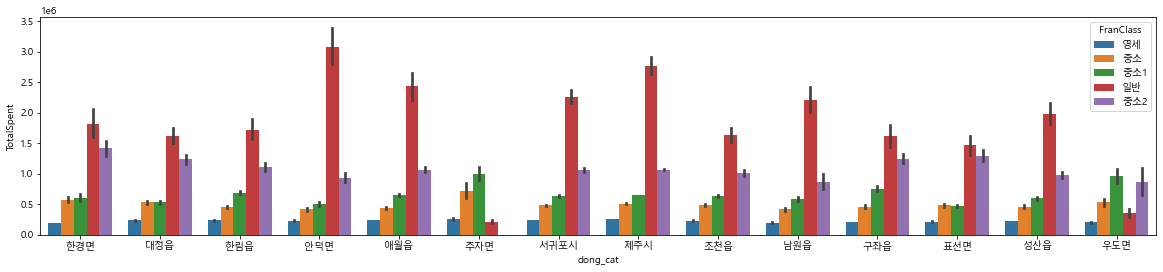

In [63]:
# 지역별-업종규모별 총사용금액 
f, ax = plt.subplots(figsize=(20,4))
sns.barplot(x='dong_cat', y ='TotalSpent', data=jeju_all, hue='FranClass')

#### 지역별-업종규모별 총사용금액 비교 시 일반 업종 관련 
- 타 업종에 비해 일반업종이 낮은 지역 : 우도면, 추자면의 경우 도서지역으로 매출액 3억원 이상의 업종 입점 규모가 낮을 것을 유추해보았습니다.  
- 일반 업종이 다른 업종 대비 2배 이상 높은 지역 
    - 제주시, 서귀포시 : 각 시의 중심 상권 지역으로 총 사용금액이 높을 것임 
    - 안덕면 , 애월읍 , 남원읍 : 어떤 업종으로 인하여 총 사용금액이 높은지 추가 확인 필요하여 아래와 같이 비교 하였습니다. 


In [ ]:
cond1 = jeju_all['SIGUNGU'] == '서귀포시'
cond2 = jeju_all['dong'].str.contains('안덕면')
df_reg_adm = jeju_all[cond1&cond2]
df_reg_adm_cat = df_reg_adm.groupby(['Type']).sum()
df_reg_adm_cat = df_reg_adm_cat.sort_values('TotalSpent', ascending=False)
df_reg_adm_cat = df_reg_adm_cat.reset_index()


cond1 = jeju_all['SIGUNGU'] == '제주시'
cond2 = jeju_all['dong'].str.contains('애월읍')
df_reg_awe = jeju_all[cond1&cond2]
df_reg_awe_cat = df_reg_awe.groupby(['Type']).sum()
df_reg_awe_cat = df_reg_awe_cat.sort_values('TotalSpent', ascending=False)
df_reg_awe_cat = df_reg_awe_cat.reset_index()


cond1 = jeju_all['SIGUNGU'] == '서귀포시'
cond2 = jeju_all['dong'].str.contains('남원읍')
df_reg_nwe = jeju_all[cond1&cond2]
df_reg_nwe_cat = df_reg_nwe.groupby(['Type']).sum()
df_reg_nwe_cat = df_reg_nwe_cat.sort_values('TotalSpent', ascending=False)
df_reg_nwe_cat = df_reg_nwe_cat.reset_index()


plt.figure(figsize=(10,3))
sns.barplot(x='Type', y ='TotalSpent', data=df_reg_adm_cat[:10],palette = 'Blues_d')
plt.title('안덕읍 총사용금액 상위 10개 업종')

plt.figure(figsize=(10,3))
sns.barplot(x='Type', y ='TotalSpent', data=df_reg_awe_cat[:10],palette = 'Blues_d')
plt.title('애월읍 총사용금액 상위 10개 업종')


plt.figure(figsize=(10,3))
sns.barplot(x='Type', y ='TotalSpent', data=df_reg_nwe_cat[:10],palette = 'Blues_d')
plt.title('남원읍 총사용금액 상위 10개 업종')


#### 안덕면, 애월읍, 남원읍 업종별 분석
- 골프경기장, 콘도 등의 일반업종이 밀집 지역임을 알 수 있음

<AxesSubplot:xlabel='dong_cat', ylabel='TotalSpent'>

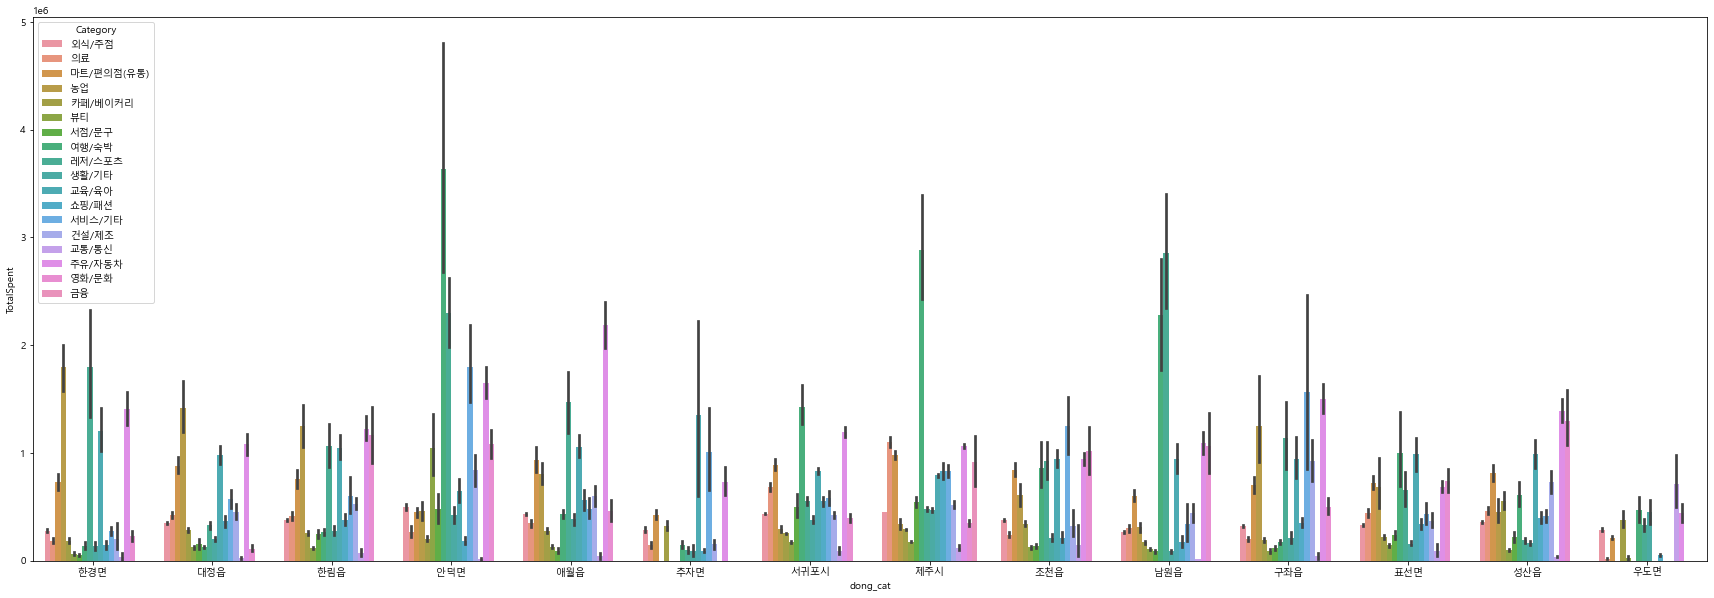

In [67]:
# 지역별-업종별(분류) 총사용금액 
f, ax = plt.subplots(figsize=(30,10))
sns.barplot(x='dong_cat', y ='TotalSpent', data=jeju_all, hue='Category')

#### 지역별 - 업종별(분류) 분포 확인 
- 각 지역별 다른 업종에서 소비가 높음을 보여주지만, 대부분의 지역의 경우 주유/자동차 업종의 일정 이상 분포를 보입니다.
- 이는 제주도 관광 사업 중 렌터카 영역에 대한 발달의 영향임을 알 수 있습니다.
- 추가로 제주 지역의 경우 1인당 자동차 등록대수 0.9대로 전국 1인당 등록대수보다 높아 주유/자동차 관련 업종의 소비가 높음을 알 수 있습니다.
(참조 : 통계청 1인당 자동차 등록대수 2019년 기준 자료)
(url : https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_1YL20731&conn_path=I2)

# 2. 재난지원금 분석 - 기간별

월별 총 사용금액과 월별 재난지원금 총 사용금액을 시각화해 보았습니다.

<AxesSubplot:xlabel='YM', ylabel='DisSpent'>

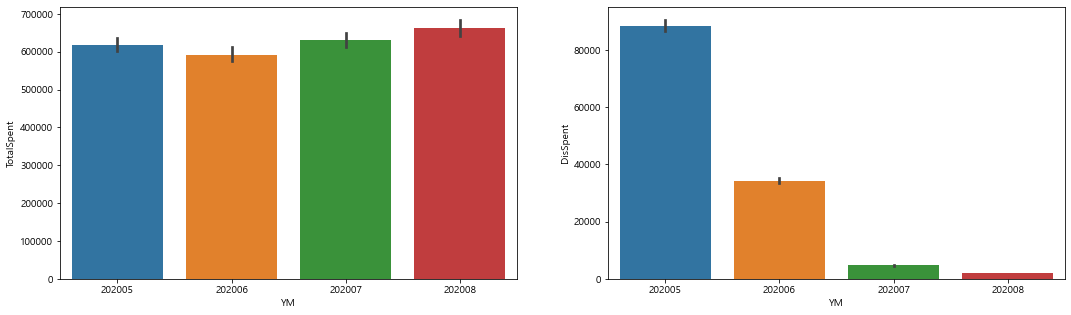

In [27]:
# 월별 총 사용금액과 월별 재난지원금 총 사용금액 

figure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(18,5)


sns.barplot(data=jeju_all, x="YM", y="TotalSpent", ax=ax1)
sns.barplot(data=jeju_all, x="YM", y="DisSpent", ax=ax2)

#### 월별 총사용금액의 차이는 크게 보이지 않으나 대부분의 재난지원금은 5월에 사용되었음을 알 수 있습니다.


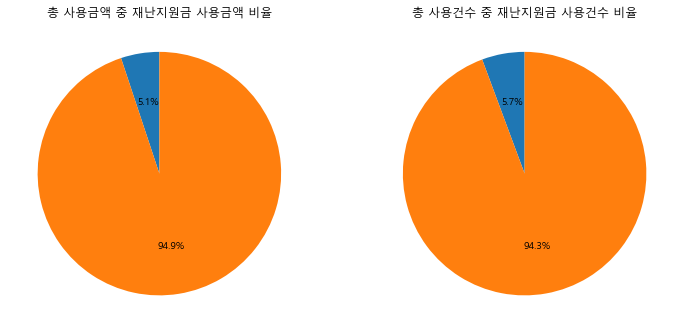

In [28]:
# 전체 기간의 소비 대비 재난지원금 사용비율

fig = plt.figure(figsize=[12, 10])

title = "총 사용금액 중 재난지원금 사용금액 비율"
sizes = [jeju_all.DisSpent.mean()*100/jeju_all.TotalSpent.mean(), 100-(jeju_all.DisSpent.mean()*100/jeju_all.TotalSpent.mean())] 
ax1 = fig.add_subplot(1, 2, 1)
ax1 = plt.pie(sizes, autopct='%1.1f%%', startangle=90)
ax1 = plt.title(title)

title = "총 사용건수 중 재난지원금 사용건수 비율"
sizes = [jeju_all.NumofDisSpent.mean()*100/jeju_all.NumofSpent.mean(), 100-(jeju_all.NumofDisSpent.mean()*100/jeju_all.NumofSpent.mean())] 
ax2 = fig.add_subplot(1, 2, 2)
ax2 = plt.pie(sizes, autopct='%1.1f%%', startangle=90)
ax2 = plt.title(title)

plt.show()

#### 전체 소비중 재난지원금의 사용 비율은 5% 정도입니다.

In [29]:
jeju_total = jeju_all.groupby('YM')['TotalSpent'].sum()
jeju_dis = jeju_all.groupby('YM')['DisSpent'].sum()
jeju_month = jeju_total/jeju_all.TotalSpent.sum()
jeju_p = jeju_dis/jeju_total

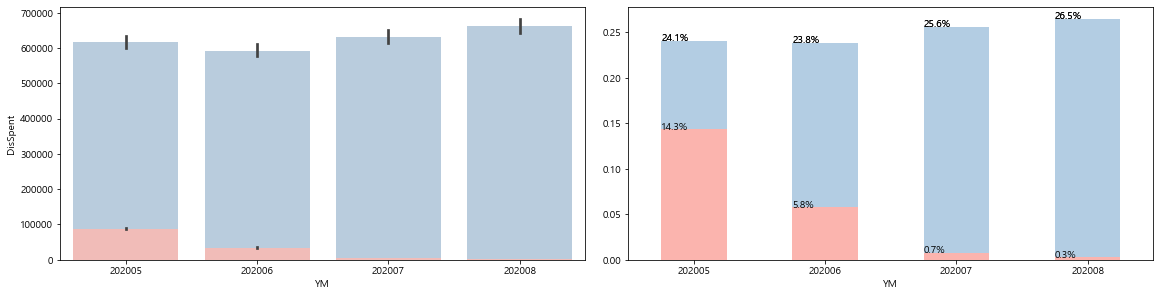

In [30]:
# 월별 총사용금액 - 총사용금액 대비 재난지원금 확인 

figure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
figure.set_size_inches(16,4)

sns.barplot(x='YM', y ='TotalSpent', data=jeju_all, color='#b3cde3', ax=ax1)
sns.barplot(x='YM', y ='DisSpent', data=jeju_all, color='#fbb4ae', ax=ax1)


# 총 사용금액의 월별 사용비율 
# 재난지원금 월별 사용 비율
ax2 = jeju_month.plot.bar(x='YM', y='0', rot=0, color='#b3cde3')
for p in ax2.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height())
    x = p.get_x()
    y = p.get_y() + p.get_height()
    ax2.annotate(percentage, (x, y))
ax2 = jeju_p.plot.bar(x='YM', y='0', rot=0, color='#fbb4ae')
for p in ax2.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height())
    x = p.get_x()
    y = p.get_y() + p.get_height()
    ax2.annotate(percentage, (x, y))

In [31]:
sukbak = jeju_all[(jeju_all['Type'].isin(('기타숙박업', '특급호텔', '2급호텔', '1급호텔', '콘도', '렌트카', '기타교통수단')))]

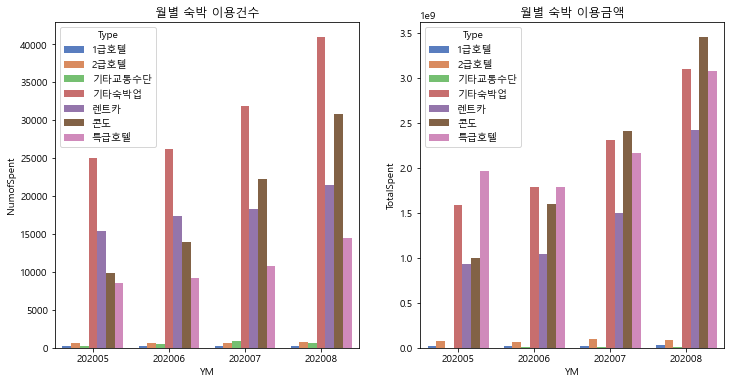

In [32]:
# 숙박 업종의 월별 총 이용건수와 총 이용금액

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax1 = sns.barplot(x='YM', y='NumofSpent', hue='Type', data=sukbak.groupby(['YM', 'Type'], as_index=False)['NumofSpent'].sum(), palette='muted')
ax1.set_title('월별 숙박 이용건수')

ax2 = fig.add_subplot(122)
ax2 = sns.barplot(x='YM', y='TotalSpent', hue='Type', data=sukbak.groupby(['YM', 'Type'], as_index=False)['TotalSpent'].sum(), palette='muted')
ax2.set_title('월별 숙박 이용금액')
plt.show()

##### 재난지원금 사용이 집중된 5월과 재난 지원금 사용이 낮은 8월의 총사용금액은 비슷함을 확인하였습니다. 

* 5월 총사용금액의 약 20%는 재난지원금에 의한 소비임을 확인하였습니다. 
* 이를 통해 5월의 총 사용금액이 8월 대비 높은 경우, 어떤 업종/지역/업종규모에 재난지원금이 사용되었는지를 파악할 수 있습니다.
* 5월 총 사용금액이 다른 월의 총사용금액과 비슷한 이유는 5월에 재난지원금이 많이 사용되었기 때문입니다. 
* (5월 관광객(33,347),  8월 관광객(74,795) 관광객이 2배가 넘음에도 불구하고 5,8월 총 사용금액은 비슷합니다.
* [출처: 제주관광공사 외국인관광객 입도통계 'https://ijto.or.kr/korean/pds_search/search.php?cid=184']
* 월별 관광객 수의 증가에 따라 숙박 이용건수와 이용금액은 증가하고 있지만 5월과 8월의 총사용금액이 비슷한 것은 재난지원금의 영향으로 분석 됩니다.
* 1) 5월과 재난지원금 사용금액이 거의 없는 8월의 소비를 분석해보면 어느 업종/지역/규모업종의 재난지원금이 사용되었는지 확인 할 수 있을 것 입니다.
* 2) 어느 업종/지역/규모업종에 재난지원금이 사용되었는지에 따라 지원 정책의 효과를 본 업종/지역/규모업종에 대한 결론을 확인할 수 있습니다.

In [33]:
jeju_all['count'] = 1

In [34]:
# 월별 업종별 총 개수, 총 이용건수와 총 지원금 사용건수로 그룹핑 하기

may_num = jeju_all[jeju_all['YM'] == 202005].groupby(['Type'], as_index=False).agg({'count': sum, 'NumofSpent': sum, 'NumofDisSpent': sum}).sort_values(by='count', ascending=False).head(10)
june_num = jeju_all[jeju_all['YM'] == 202006].groupby(['Type'], as_index=False).agg({'count': sum, 'NumofSpent': sum, 'NumofDisSpent': sum}).sort_values(by='count', ascending=False).head(10)
july_num = jeju_all[jeju_all['YM'] == 202007].groupby(['Type'], as_index=False).agg({'count': sum, 'NumofSpent': sum, 'NumofDisSpent': sum}).sort_values(by='count', ascending=False).head(10)
august_num = jeju_all[jeju_all['YM'] == 202008].groupby(['Type'], as_index=False).agg({'count': sum, 'NumofSpent': sum, 'NumofDisSpent': sum}).sort_values(by='count', ascending=False).head(10)

#### 월별, 이용건수 상위 10개 업종의 총 이용건수와 총 재난지원금 이용건수 비교

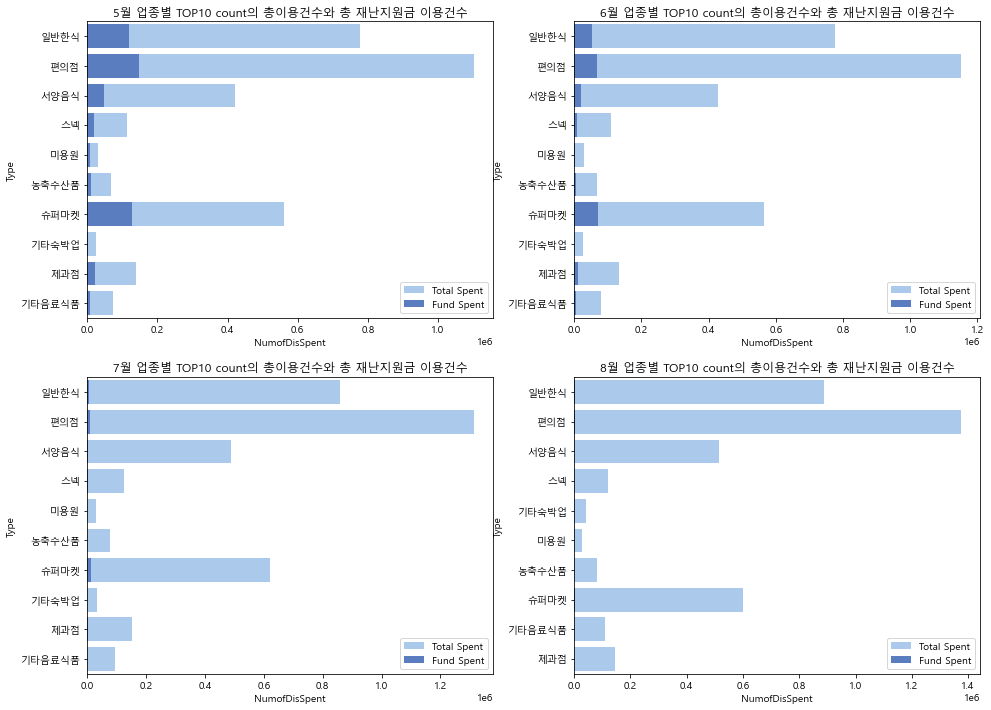

In [35]:
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(2, 2, 1)
ax1 = sns.set_color_codes('pastel')
ax1 = sns.barplot(x='NumofSpent', y='Type', data=may_num, label='Total Spent', color='b')
ax1 = sns.set_color_codes('muted')
ax1 = sns.barplot(x='NumofDisSpent', y='Type', data=may_num, label='Fund Spent', color='b')
ax1.legend(loc='best', frameon=True)
ax1.set_title('5월 업종별 TOP10 count의 총이용건수와 총 재난지원금 이용건수')

ax2 = fig.add_subplot(2, 2, 2)
ax2 = sns.set_color_codes('pastel')
ax2 = sns.barplot(x='NumofSpent', y='Type', data=june_num, label='Total Spent', color='b')
ax2 = sns.set_color_codes('muted')
ax2 = sns.barplot(x='NumofDisSpent', y='Type', data=june_num, label='Fund Spent', color='b')
ax2.legend(loc='best', frameon=True)
ax2.set_title('6월 업종별 TOP10 count의 총이용건수와 총 재난지원금 이용건수')

ax3 = fig.add_subplot(2, 2, 3)
ax3 = sns.set_color_codes('pastel')
ax3 = sns.barplot(x='NumofSpent', y='Type', data=july_num, label='Total Spent', color='b')
ax3 = sns.set_color_codes('muted')
ax3 = sns.barplot(x='NumofDisSpent', y='Type', data=july_num, label='Fund Spent', color='b')
ax3.legend(loc='best', frameon=True)
ax3.set_title('7월 업종별 TOP10 count의 총이용건수와 총 재난지원금 이용건수')

ax4 = fig.add_subplot(2, 2, 4)
ax4 = sns.set_color_codes('pastel')
ax4 = sns.barplot(x='NumofSpent', y='Type', data=august_num, label='Total Spent', color='b')
ax4 = sns.set_color_codes('muted')
ax4 = sns.barplot(x='NumofDisSpent', y='Type', data=august_num, label='Fund Spent', color='b')
ax4.legend(loc='best', frameon=True)
ax4.set_title('8월 업종별 TOP10 count의 총이용건수와 총 재난지원금 이용건수')
plt.show()

- 월별로 가장 많이 소비된 업종 TOP10 상위 4개는 일반한식, 편의점, 서양음식, 스넥으로 항상 같은 자리를 유지하였음.
- 5월에 지급된 재난지원금인만큼 이용건수가 확연하게 많다는 것을 볼 수 있는 반면 6~8월로 지나갈 수록 이용건수가 줄어들고 있음.

In [36]:
# 월별, 업종별로 각각 총 이용건수와 이용금액으로, 총 재난지원금 이용건수와 재난지원금 사용금액으로 그룹핑

type_spent = jeju_all.groupby(['YM', 'Type']).agg({'TotalSpent': sum, 'NumofSpent': sum})
type_dis = jeju_all.groupby(['YM', 'Type']).agg({'DisSpent': sum, 'NumofDisSpent': sum})

#### 월별, 개수가 상위 10개인 업종의 총 이용건수와 이용금액 & 총 재난지원금 이용건수와 재난지원금 이용금액

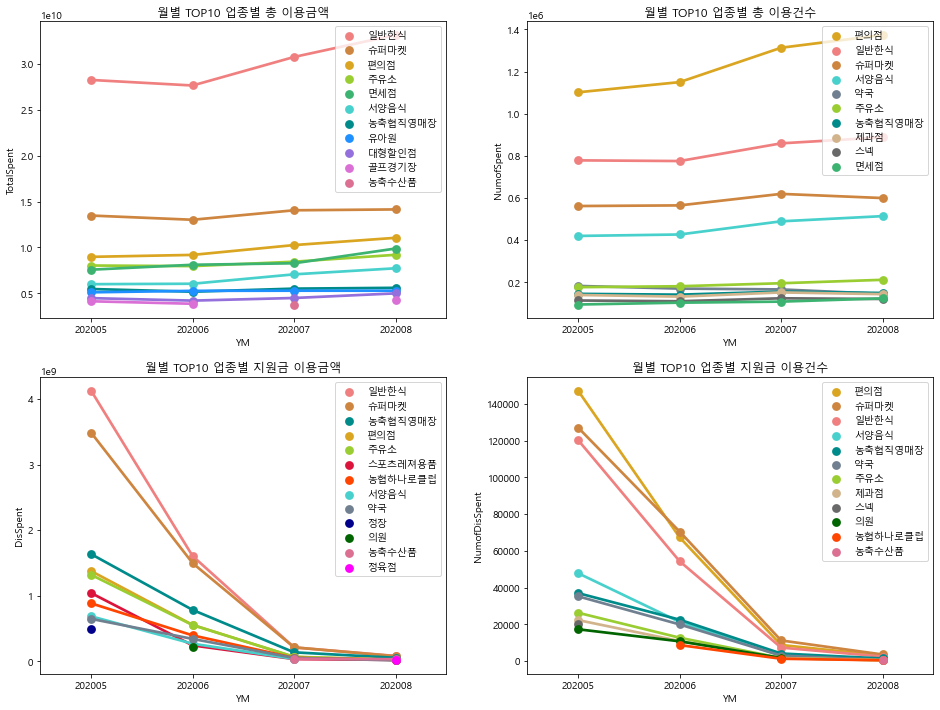

In [37]:
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(2, 2, 1)
ax1 = sns.pointplot(x='YM', y='TotalSpent', hue='Type', data=type_spent['TotalSpent'].groupby('YM', group_keys=False).nlargest(10).reset_index(), palette={'일반한식': 'lightcoral', '슈퍼마켓': 'peru', '편의점': 'goldenrod', '주유소': 'yellowgreen', '면세점': 'mediumseagreen', '서양음식': 'mediumturquoise', '농축협직영매장': 'darkcyan', '유아원': 'dodgerblue', '대형할인점': 'mediumpurple', '골프경기장': 'orchid', '농축수산품': 'palevioletred'})
ax1.set_title('월별 TOP10 업종별 총 이용금액')
ax1.legend(loc='best')

ax2 = fig.add_subplot(2, 2, 2)
ax2 = sns.pointplot(x='YM', y='NumofSpent', hue='Type', data=type_spent['NumofSpent'].groupby('YM', group_keys=False).nlargest(10).reset_index(), palette={'편의점': 'goldenrod', '일반한식': 'lightcoral', '슈퍼마켓': 'peru', '서양음식': 'mediumturquoise', '약국': 'slategrey', '주유소': 'yellowgreen', '농축협직영매장': 'darkcyan', '제과점': 'tan', '스넥': 'dimgray', '면세점': 'mediumseagreen'})
ax2.set_title('월별 TOP10 업종별 총 이용건수')
ax2.legend(loc='best')

ax3 = fig.add_subplot(2, 2, 3)
ax3 = sns.pointplot(x='YM', y='DisSpent', hue='Type', data=type_dis['DisSpent'].groupby('YM', group_keys=False).nlargest(10).reset_index(), palette={'일반한식': 'lightcoral', '슈퍼마켓': 'peru', '농축협직영매장': 'darkcyan', '편의점': 'goldenrod', '주유소': 'yellowgreen', '스포츠레져용품': 'crimson', '농협하나로클럽': 'orangered', '약국': 'slategrey', '정장': 'darkblue', '의원': 'darkgreen', '농축수산품': 'palevioletred', '정육점': 'magenta', '서양음식': 'mediumturquoise'})
ax3.set_title('월별 TOP10 업종별 지원금 이용금액')
ax3.legend(loc='best')

ax4 = fig.add_subplot(2, 2, 4)
ax4 = sns.pointplot(x='YM', y='NumofDisSpent', hue='Type', data=type_dis['NumofDisSpent'].groupby('YM', group_keys=False).nlargest(10).reset_index(), palette={'편의점': 'goldenrod', '슈퍼마켓': 'peru', '일반한식': 'lightcoral', '서양음식': 'mediumturquoise', '농축협직영매장': 'darkcyan', '약국': 'slategrey', '주유소': 'yellowgreen', '제과점': 'tan', '스넥': 'dimgray', '의원': 'darkgreen', '농협하나로클럽': 'orangered', '농축수산품': 'palevioletred'})
ax4.set_title('월별 TOP10 업종별 지원금 이용건수')
ax4.legend(loc='best')
plt.show()

- 월별 TOP10 업종별 총 이용금액은 일반한식이 더 높았지만 이용건수로 보았을 땐 편의점이 가장 많았음. 이는 면세점의 이용건수에서의 순위 대비 이용금액 순위에서 볼 수 있듯이, 상대적으로 가격대가 더 높은 일반한식이라서 이용 건수는 편의점보다 적더라도 사용 금액은 더 높을 수 있음.
- 월별 TOP10 업종별 총 재난지원금 이용금액은 일반한식 다음으로 슈퍼마켓 순서로 가장 많았으며 이용건수는 편의점 다음으로 슈퍼마켓이 많았음. 위와 마찬가지로 금액대 차이로 인해 발생하는 것으로 알 수 있음. 
- 월별 TOP10 업종별 총 재난지원금 이용금액과 이용건수에서 볼 수 있듯이 시간이 지남에 따라 급격하게 소비가 줄어듦.

# 3. 재난지원금 - 업종별 
1. 8월 대비 5월에 사용이 더 많은 업종은 재난 지원금 사용의 결과일 것으로 생각됩니다.
2. 따라서 5월과 8월 총사용금액을 업종별로 비교하여 재난지원금의 효과를 분석해 보고자 합니다.

In [38]:
# 5월과 8월 데이터를 따로 분리 합니다.

cond1 = jeju_all['YM'] == 202005
cond2 = jeju_all['YM'] == 202008
jeju_may_aug = jeju_all[cond1|cond2]

jeju_may_aug.head()

OBJECTID  Field1      YM     SIDO SIGUNGU FranClass  Type Time  TotalSpent  \
0         1       1  202005  제주특별자치도     제주시        영세  일반한식   00      363000   
1      4904    4904  202005  제주특별자치도     제주시        영세  일반한식   01       86500   
2      8569    8569  202005  제주특별자치도     제주시        영세  일반한식   02      208000   
3     11270   11270  202005  제주특별자치도     제주시        영세  일반한식   03       18000   
4     19122   19122  202005  제주특별자치도     제주시        중소   한의원   07        4800   

   DisSpent  NumofSpent  NumofDisSpent      POINT_X       POINT_Y  \
0     66500          10              2 877005.98340 1479766.07300   
1         0           3              0 877005.98340 1479766.07300   
2         0           5              0 877005.98340 1479766.07300   
3         0           1              0 877005.98340 1479766.07300   
4         0           2              0 877005.98340 1479766.07300   

                  lon                lat  \
0  126.17889362710162  33.30231529076243   
1  126.17889362710162  33.30231529076243   
2  126.17889362710162  33.30231529076243   
3  126.17889362710162  33.30231529076243   
4  126.17889362710162  33.30231529076243   

                                lon_lat dong Category Time_cut  dis/tot  count  
0  126.17889362710162_33.30231529076243  한경면    외식/주점       심야  0.20000      1  
1  126.17889362710162_33.30231529076243  한경면    외식/주점       심야  0.00000      1  
2  126.17889362710162_33.30231529076243  한경면    외식/주점       새벽  0.00000      1  
3  126.17889362710162_33.30231529076243  한경면    외식/주점       새벽  0.00000      1  
4  126.17889362710162_33.30231529076243  한경면       의료       오전  0.00000      1

### 업종별 5월 8월 소비금액 비교

<AxesSubplot:xlabel='Category', ylabel='TotalSpent'>

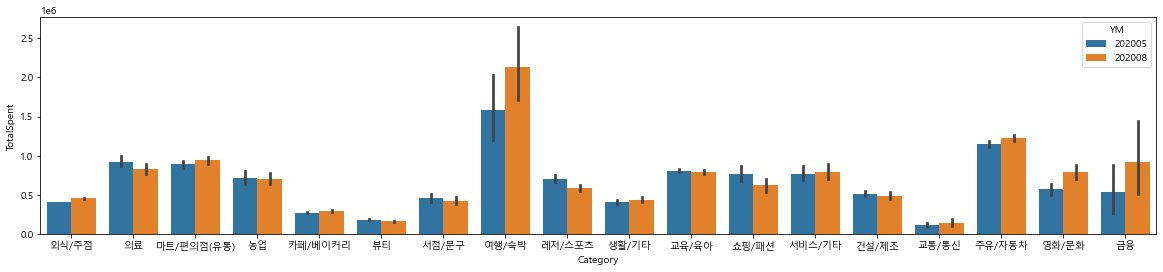

In [39]:
f, ax = plt.subplots(figsize=(20,4))
sns.barplot(x='Category', y ='TotalSpent', data=jeju_may_aug, hue='YM')

#### 1. 의료, 레저/스포츠, 교육/육아, 쇼핑/패션 분야에서 5월 사용금액이 8월 보다 높습니다. 
#### 2. 이는 재난지원금으로 소비 촉진이 일어난 업종일 것으로 생각됩니다.

# 4. 재난지원금 사용 분석 - 지역별 

1. 지역별-월별 총 사용금액 중 5월 사용이 많은 지역은 재난지원금에 의해 소비가 촉진된 지역일 가능성이 있습니다. 
2. 이에 5월 총 사용금액이 8월 총 사용금액보다 높은 지역을 분석해보고자 합니다.

<AxesSubplot:xlabel='dong_cat', ylabel='TotalSpent'>

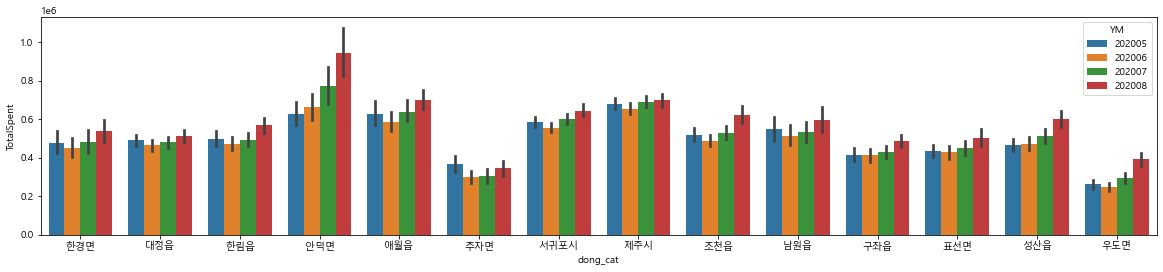

In [43]:
# 지역별-월별 총사용금액을 시각화해 보았습니다.

f, ax = plt.subplots(figsize=(20,4))
sns.barplot(x='dong_cat', y ='TotalSpent', data=jeju_all, hue='YM')

#### 총사용금액 5월 8월 비교 읍면동별 구분 
- 재난지원금이 20% 이상 차지하는 5월은 재난지원금이 없었다면 8월 총사용금액에 비해 낮아야 합니다.
- 즉, 5월과 8월의 총 사용금액이 비슷한 지역의 경우, 재난지원금의 영향으로 소비가 촉진된 지역일 것이라고 생각합니다. 


#### 제주시와 추자면의 경우 5월과 8월의 사용금액이 거의 비슷합니다. 
- 제주시 : 제주도 핵심 상권 지역으로 대부분의 상점, 편의시설 등이 몰려있으므로 재난지원금 사용이 높았을 것 입니다. 
- 추자면 : 제주도 북부에 멀리 떨어진 도서 지역입니다. 물리적으로 재난지원금을 다른 지역에서 소비하기 어려웠을 것으로 생각됩니다. 

#### 5월, 8월 총사용금액  제주시/서귀포시로 구분 

<AxesSubplot:xlabel='SIGUNGU', ylabel='TotalSpent'>

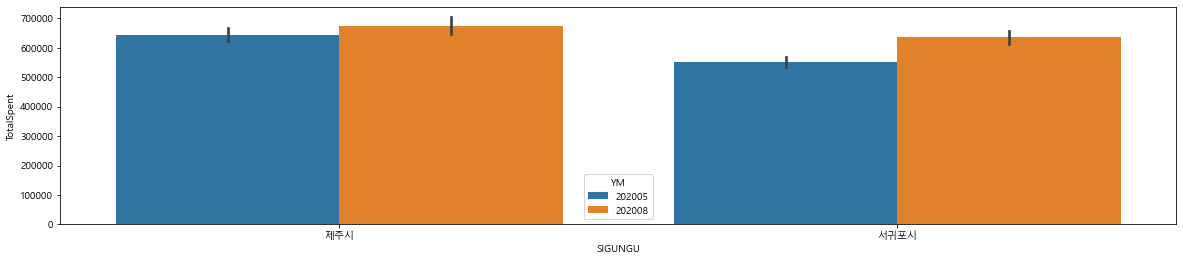

In [44]:
f, ax = plt.subplots(figsize=(20,4))
sns.barplot(x='SIGUNGU', y ='TotalSpent', data=jeju_may_aug, hue='YM')

- 제주시가 서귀포시에 비해 재난지원금의 상대적 효과가 큰 것으로 생각됩니다.
- 제주시는 서귀포시에 비해 생활관련 업종이 밀집되어 있으므로 재난지원금의 사용이 높았을 것으로 생각됩니다.

# 5. 재난지원금 사용분석 - 업종규모별 

<AxesSubplot:xlabel='FranClass', ylabel='TotalSpent'>

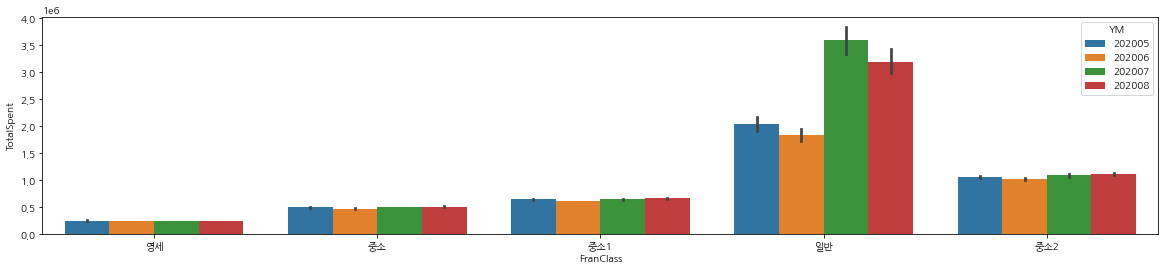

In [21]:
# 업종규모별 총사용금액을 시각화하여 분석합니다. 

f, ax = plt.subplots(figsize=(20,4))
sns.barplot(x='FranClass', y ='TotalSpent', data=jeju_all, hue='YM')

#### 일반 업종은 재난지원금 효과 낮음 그외 효과 있었음 
- 일반 업종의 대부분은 면세점, 골프장 등의 재난지원금을 사용할 수없는 업종이 많아 재난지원금의 효과는 낮습니다.
- 아래 그래프를 보면 일반업종을 제외하고 모두 비슷한 소비형태와 총 사용금액을 볼 수 있습니다.

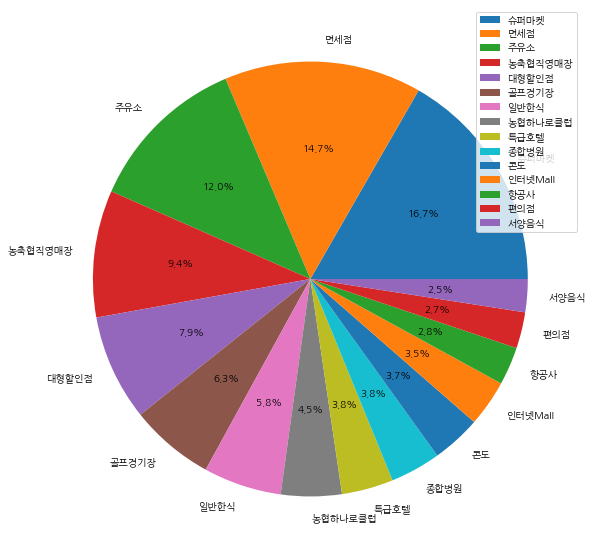

In [22]:
# 총 사용금액 중 일반 업종 규모에 해당하는 업종타입 확인 
plt.figure(figsize=(10,10))

jeju_class_norm = jeju_all[jeju_all['FranClass'] == '일반']
df_norm = jeju_class_norm.groupby('Type').sum()
df_norm = df_norm.sort_values(['TotalSpent'], ascending= [False]).head(15)

data = df_norm['TotalSpent'].values[:15]
cat = df_norm['TotalSpent'].index[:15]

plt.pie(data, labels=cat, autopct='%0.1f%%')
plt.legend(cat)

plt.show()

In [23]:
#### 재난지원금 사용불가 업종 : 
- 대형마트, 골프경기장, 면세점, (기업형)슈퍼마켓, 온라인전자 업종에서 사용 불가 
- 일반 업종규모의 경우 상위 대부분이 재난지원금 사용 불가 업종이었음 

SyntaxError: invalid syntax (<ipython-input-23-dd993b444ad6>, line 2)

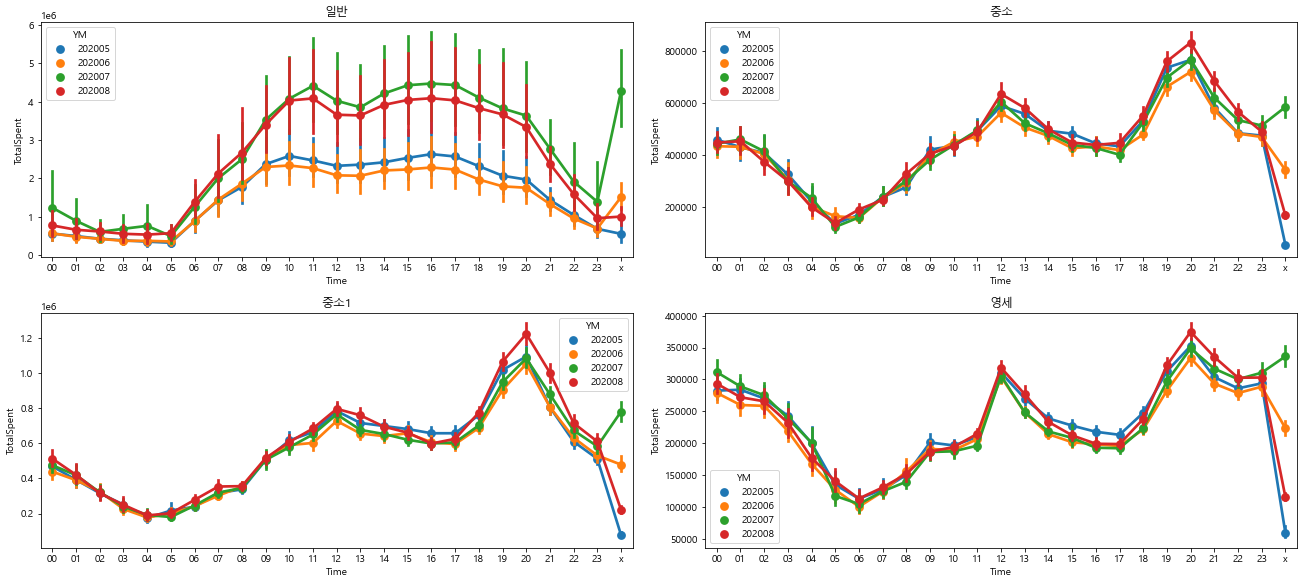

In [46]:
figure, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
figure.set_size_inches(18,8)

sns.pointplot(data=jeju_all[jeju_all['FranClass']=='일반'], x="Time", y="TotalSpent", hue='YM',ax=ax1, order = ['00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21', '22', '23', 'x'])
sns.pointplot(data=jeju_all[jeju_all['FranClass']=='중소'], x="Time", y="TotalSpent",hue='YM', ax=ax2, order = ['00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21', '22', '23', 'x'])
sns.pointplot(data=jeju_all[jeju_all['FranClass']=='중소1'], x="Time", y="TotalSpent",hue='YM', ax=ax3, order = ['00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21', '22', '23', 'x'])
sns.pointplot(data=jeju_all[jeju_all['FranClass']=='영세'], x="Time", y="TotalSpent",hue='YM', ax=ax4, order = ['00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21', '22', '23', 'x'])
ax1.set_title("일반")
ax2.set_title("중소")
ax3.set_title("중소1")
ax4.set_title("영세")

plt.show();

#### 일반업종 ..
- 일반 업종의 경우 재난지원금 사용이 불가하여 7,8월 대비 5,6월의 소비가 유독 낮습니다.
- 7,8월의 경우 5,6월 대비 관광객의 유입이 많아 관광 관련 업종인 면세점, 골프경기장, 특급호텔 등의 소비의 증가로 7,8월 일반 업종의 소비 증대되었을 것 입니다. 

# 결론 

### 1. 제주도의 전반적인 소비패턴 
    
    1) 월별 : 
      - 휴가철인 8월에 소비가 집중될 것으로 예상하였으나, 5~8월 총 사용금액의 차이는 크게 두드러지지 않았습니다.(5월에 풀린 재난지원금의 영향일 
      것으로 보입니다)전체기간에서 면세점의 사용금액이 압도적으로 우세하였고, 항공사, 대형할인점, 조세서비스, 종합병원 등이 그 뒤를 이었습니다.
 
    2)시간별:
      - 총사용금액에 대해 시간별로 많이 소비되는 업종을 살펴보면 새벽에는 주점과 편의점, 오전에는 출근 시간의 영향으로 주유소, 점심시간대와 
      저녁시간대에는 일반한식 업종이 높게 나타나며 전 시간대에 걸쳐 면세점의 소비가 높고, 종합병원, 의원, 골프경기장도 상위권에 속해 있습니다.
      - 재난지원금은 재난지원금을 사용할 수 없는 면세점, 대형마트, 유흥주점을 제외하면 총 사용금액과 유사한 소비행태를 보입니다. 또한 전 시간대에 
      슈퍼마켓, 농협하나로 클럽, 편의점 등 생활밀착형 업종에서 재난지원금이 많이 사용됩니다.
      - 제주시와 서귀포시의 총 사용금액을 시간별로 분석하여 상위 10개 업종을 뽑아 봤을 때 두 지역 모두 일반한식, 슈퍼마켓 등 생활 소비업종에서 
      소비가 높은 것으로 분석해보았습니다. 다만,제주시는 면세점이 총 소비의 상위권을 차지하고 있으며 주거 밀집지역의 특성상 종합병원과 의원, 
      약국이 높은 것으로 분석됩니다. 서귀포시는 콘도, 골프경기장, 특급호텔에서의 소비가 높은 것을 그래프를 통해 확인할 수 있었습니다.  
 
    3)업종별: 
      - 각 업종별로 이용건수가 많다고 하더라도 총 사용 금액이 똑같이 높아지지 않습니다.
      - 이는 각 업종별로 제공하는 금액대가 다르기 때문에 저렴한 종목에서 여러 건수가 발생한 것이 고가의 종목에서는 건수가 하나만 발생한 것과 같은 
      이용금액으로 나타날 수 있습니다.
      - 이용건수 분포가 명확하게 드러나는 식음료 유통 업종과 외식업종을 보았을 때, 일반적으로 지키는 점심시간(12시)과 저녁시간(18-19시)에 가장 
      높은 이용 건수 와 이용 금액을 볼 수 있었습니다.
      - 여행 관련 업종 중 숙박 시설만을 모아서 보았을 때, 대부분 재난지원금 사용이 거의 없는 8월에 가장 많이 소비되었습니다. 이는 8월 관광객 
      수가 5월 관광객 수의 2배가 넘어 발생하였던 결과인 것으로 분석 되었습니다.
 
    4)지역별: 
      - 지역에 구분없이 일반한식, 슈퍼마켓 등 생활 밀착형 업종에서의 소비금액이  높습니다. 이는 제주도민과 관광객 모두의 영향으로 볼 수 있습니다. 
      - 제주시의 경우  면세점의 사용금액이 매우 높으며, 종합병원, 의원, 약국등의 소비가 많은 것으로 보아 생활 밀착 업종이 제주시에 밀집되어 있음을 
        확인 하였습니다.
      - 서귀포시의 경우  콘도, 골프경기장 특급호텔에서의 소비가 눈에 띄는 것을 확인하였습니다. 생활권보다 관광지로서의 더욱 발달 되었음을 확인할 
        수 있습니다.


### 2. 재난지원금 사용 분석 : 
    1) 기간별 
       - 월별 총사용금액의 경우 차이는 크게 보이지 않으나, 재난지원금의 총 사용금액의 경우 5월에 집중되었음을 확인하였습니다.
       - 재난지원금 사용이 집중된 5월, 재난지원금 사용이 낮은 8월의 총 사용금액이 비슷함을 확인하였습니다.
       - 5월과 8월의 소비를 분석해보면 어느 지역/업종/업종규모에서의 재난지원금이 사용되었는지 확인할 수 있음을 유추하였고, 이를 기반으로 
         지역/업종/업종 규모별 분석을 하였습니다. 
       
    2) 지역별 
       - 지역별 월별 총사용금액을 비교  분석하였을 때, 제주시와 추자면의 경우 5월과 8월의 총 사용금액이 비슷함을 확인하였습니다.
        * 제주시의 경우 제주도 핵심 상권 지역으로 대부분의 상점, 편의시설 등이 몰려있으므로 재난지원금 사용이 높았을 것 입니다.
        * 추자면의 경우 제주도 북부에 멀리 떨어진 도서 지역입니다. 물리적으로 재난지원금을 다른 지역에서 소비하기 어려웠을 것으로 분석하였습니다. 
        
    3) 업종별  
       - 의료, 레저/스포츠, 교육/육아, 쇼핑/패션 분야에서 5월 사용금액이 8월 보다 높음을 확인하였고 이는 재난지원금으로 소비가 촉진된 업종으로 
         분석하였습니다. 
         
    4) 업종규모별 
       - 일반업종의 경우 재난 지원금 효과가 낮았고 대부분의 업종이 면세점, 골프장, 대형할인장 등의 재난지원금 사용불가 업종에 해당하여 기인한 것으로 
         분석하였습니다. 

